# <b>Colab-friendly Codes for Figures</b>

- Tested with Colab Release 2024-09-23

# <b>Libraries and Settings</b>

## Path Setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab\ Notebooks/MitoticWaves
# The path should contain ./lib_mitotic_waves.py, ./figures.ipynb, and data drives (./sim/* and ./exp/*)

In [ ]:
!pip install rasterio
!pip install f90nml

In [1]:
from lib_mitotic_waves import *

import sys
sys.path.append('packages')
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcol
import scipy.stats as stats
lowess = sm.nonparametric.lowess
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams,colors
from matplotlib.colors import LinearSegmentedColormap
from skimage import io
from skimage.restoration import inpaint
from scipy import signal
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')
from matplotlib.patches import Polygon
import nuclei as nuc



## Default parameters

In [2]:
p_0 = {'ks':1.5,
       'a_cdc25':0.8, 'b_cdc25':4, 'ec50_cdc25':35, 'n_cdc25':11,
       'a_wee1':0.4, 'b_wee1':2, 'ec50_wee1':30, 'n_wee1':3.5,
       'a_deg':0.01, 'b_deg':0.06, 'ec50_deg':32, 'n_deg':17,
       'Da':1,'Di':1,'tau':1,'alpha':1,'beta':1}
Da_u = 240*1e-6 # mm*2/min
chi = np.sqrt(Da_u)

## Plot Settings & Example Visualization Macros

In [3]:
plt.rcdefaults()

plt.rcParams.update({
    "font.family":"sans-serif",
    "font.sans-serif":["Liberation Sans"],
    "figure.figsize": (1.6*4, 4),
    "text.usetex": False,
    "axes.titlesize" : 10,
    "axes.labelsize" : 10,
    "legend.fontsize": 10,
    "legend.fontsize": 10,
    "xtick.labelsize" : 9,
    "ytick.labelsize" : 9,
    "xtick.major.width" : .75,
    "ytick.major.width" : .75,
    "savefig.dpi": 300,
})


def set_size(ax, width, height):
    r"""Set figure size in inches."""
    hbox = ax.figure.subplotpars.right - ax.figure.subplotpars.left
    wbox = ax.figure.subplotpars.top - ax.figure.subplotpars.bottom

    ax.figure.set_size_inches(width / wbox, height / hbox)


def draw_spatial_profile(
        img,
        spc,
        dt,
        saveas,
        strt,
        end_,
        strt_c=None,
        end_c=None,
        cmap=None,
        xticks=None,
        ylim=None,
        size=(1, 1),
        interval=2,
    ):
    r"""Draw spaital profiles of a kymograph."""
    filled_cropped_image = inpaint.inpaint_biharmonic(img, np.isnan(img))

    ## Detrend Data
    # Calculate the average FRET ratio at the beginning and end of the image
    start_trend = np.nanmean(filled_cropped_image[:,0])
    end_trend = np.nanmean(filled_cropped_image[:,-1])
    # Get the total change in FRET ratio
    delta_FRET = abs(start_trend - end_trend)
    # Assume the decay is linear and detrend the data using this assumption
    trendline = np.linspace(0.0, delta_FRET, np.shape(filled_cropped_image)[1])
    trend = - np.tile(trendline, (np.shape(filled_cropped_image)[0], 1))
    filled_cropped_detrended_image = (filled_cropped_image - trend)
    # Rename
    image = filled_cropped_detrended_image

    fig=plt.figure()

    if cmap is None:
        cmap = mcol.LinearSegmentedColormap.from_list("MyCmapName",["red", "blue"])

    if strt_c is None:
        strt_c = strt

    if end_c is None:
        end_c = end_

    # Make a normalizer that will map the time values from
    # [start_time,end_time+1] -> [0,1].
    vmin = dt * strt
    vmax = dt * end_

    vmin_c = dt * strt_c
    vmax_c = dt * end_c
    cnorm = mcol.Normalize(vmin=vmin_c, vmax=vmax_c)

    # Turn these into an object that can be used to map time values to colors and
    # can be passed to plt.colorbar().
    cpick = cm.ScalarMappable(norm=cnorm, cmap=cmap)
    cpick.set_array([])

    for j in range(strt,end_,interval):
        temp = signal.savgol_filter(np.flip(image[:,j]), 9, 3)
        temp2 = signal.detrend(temp)
        temp1 = temp2-np.mean(temp2) - (j - strt) * 0.1
        plt.plot((spc/len(image[:,j]))*np.linspace(0,len(temp1),len(temp1)),np.flip(temp1),color=cpick.to_rgba(dt*j),linewidth=0.75)

    ax = plt.gca()
    set_size(ax, *size)

    if xticks is not None:
        plt.xlim(xticks[0], xticks[-1])
        plt.xticks(xticks)

    if ylim is not None:
        plt.ylim(ylim)

    plt.yticks([])

    plt.xlabel("Space (mm)")
    plt.ylabel("FRET ratio")

    pos = ax.get_position()
    cax = fig.add_axes([pos.x1 + 0.025 / size[0], pos.y0, 0.05 * 1.25 / size[0], pos.y1 - pos.y0])
    fig.colorbar(
        mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=vmin_c, vmax=vmax_c), cmap=cmap),
        orientation='vertical',
        cax=cax,
        ticks=[vmin_c, vmax_c],
    )
    cax.xaxis.set_ticks_position('top')
    cax.invert_yaxis()

    plt.savefig(saveas, bbox_inches="tight")


def plot_kde(
        xx,
        yy,
        dens,
        wnx,
        wny,
        xticks,
        yticks,
        fit=False,
        cmap=None,
        size=(1.25, 0.75),
        draw_density=True,
        draw_axis=True,
        fig=None,
        ax=None,
        col1="#629364",
        col2="#B3E1B5",
    ):
    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = plt.gca()

    if cmap is None:
        cmap = custom_colormap(['#FFFFFF','#EEEEEE','#808080'])

    if draw_density:
        im = ax.pcolormesh(xx,yy,dens,cmap=cmap)

    if fit:
        popt, pcov = curve_fit(lambda t, a, b, c: c - a * np.exp((-1)*(t)/ b), wnx, wny, bounds=(0, [0.1, 3000., 0.05]))
        a = popt[0]
        b = popt[1]
        c = popt[2]

        x_fitted = np.linspace(np.min(wnx_S), np.max(wnx_S), 100)
        y_fitted = c - a * np.exp((-1)* (x_fitted)/b)

    if draw_axis:
        if fit:
            ax.plot(x_fitted,y_fitted,'k--',zorder=20,linewidth=0.75)

        ax.plot(wnx,wny,c=col1,linewidth=2)
        #ax.scatter(xx,yy[np.argmax(dens,axis=0)],facecolor=col2,s=2, marker='.')

    ax.set_xlim([xticks[0], xticks[-1]])
    ax.set_ylim([yticks[0], yticks[-1]])

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    set_size(ax, *size)

    if not draw_axis:
        plt.axis('off')


def cmap_nonlin(cmap, v1map, v2map):
    r"""Define a nonlinear colormap."""
    clist = [(v, cmap(c)) for v, c in zip(np.linspace(0, v1map[0], num=50), np.linspace(0, v1map[1], num=50))]
    clist += [(v, cmap(c)) for v, c in zip(np.linspace(v1map[0], v2map[0], num=50), np.linspace(v1map[1], v2map[1], num=50))]
    clist += [(v, cmap(c)) for v, c in zip(np.linspace(v2map[0], 1, num=50), np.linspace(v2map[1], 1, num=50))]

    cmap = mcol.LinearSegmentedColormap.from_list(
        "NonlinMap",
        clist,
    )

    return cmap


def extract_data_plt_new(length, dir_el, xticks, flip=False, plot_crop=False, plot_traj=False, plot_cur=False, sigma=1, order=150, vmin=None, vmax=None,cmap='jet', fig=None, ax=None, lengthticks=None):
    r"""A slightly modified version of extract_data_plt."""
    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = plt.gca()

    x,t,array,limits = dir_el['x'],dir_el['t'],dir_el['Activity'],dir_el['limits']
    x,t,array = crop(x,t,array,limits)
    if plot_crop:
        if flip:
            f = ax.pcolormesh(t,np.flipud(x),array,cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            f = ax.pcolormesh(t,x,array,cmap=cmap, vmin=vmin, vmax=vmax)

    # clean_array = recursive_fill_nans(array,sx=10,sy=10)
    clean_array = fill_nans(array,sx=15,sy=15)
    clean_array1 = fill_nans(clean_array,sx=15,sy=15)
    array0 = detrend(clean_array1,axis=1)
    array = gaussian_filter(array0, sigma=sigma)

    waves_traj = get_traj(t,x,array.T)
    new_waves_traj = reconstruct_waves(waves_traj)
    if plot_traj:
        for el in new_waves_traj:
            ax.plot(el[0],el[1],'.',markersize=2,c='66C3FF')

    waves = spl_waves_traj(new_waves_traj,t[1]-t[0])
    if plot_cur:
        for el in waves:
            if flip:
                ax.plot(el[0],np.flipud(el[1]),c='w')
            else:
                ax.plot(el[0],el[1],c='w')

    if plot_traj or plot_crop or plot_cur:
        ax.set_xlabel('Time (min)')
        ax.set_ylabel('Space (mm)')
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticks)
        ax.set_xlim([xticks[0], xticks[-1]])
        if lengthticks is None:
            tick = length / 5
            ax.set_yticks([max(plt.ylim()) - (max(plt.ylim()) - min(plt.ylim())) / 5 * i for i in range(6)])
            ax.set_yticklabels(reversed([length - tick * i for i in range(6)]))
        else:
            ax.set_yticks([max(plt.ylim()) - 1000 * i for i in lengthticks])
            ax.set_yticklabels(lengthticks)

    pos = ax.get_position()
    cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.025, pos.y1 - pos.y0])
    fig.colorbar(mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap='jet'), orientation='vertical', cax=cax, ticks=np.linspace(vmin, vmax, num=5))


## Macros for Quantitative Analysis

In [4]:
exp = lambda t, t1, a1, b: b + a1 * np.exp(-1 * t / t1)


def writetocsv(name, *args):
    df = pd.DataFrame({i: args[i] for i in range(len(args))})
    df.to_csv(name, header=False, index=False)


def detect_tail(x, y, dl_thres=0.025, min_fraction=0.25, ax=None, ax2=None, linespec='-', color='k', fname="taildetect.csv"):
    # recommended using min_fraction=0.25 for experimental data as data at later times tends to be sparse
    # use min_fraction=0 for simulation data
    n_orig = len(x)
    idx = np.arange(n_orig)
    step = int(n_orig * 0.01)
    idx = idx[:int((1 - min_fraction)*n_orig):step]
    # far tails are excluded to make first several fits work
    dec = np.zeros_like(idx, dtype=float)

    cnt = 0
    for i in idx:
        x_ = x[i:]
        y_ = y[i:]

        try:
            p, _ = curve_fit(exp, x_, y_, bounds=(0, [10000, 10000, 10000]))
        except RuntimeError:
            # this implies an optimal parameter set is not found
            sigma2 = np.nan
        else:
            n = len(x_)
            res = y_ - exp(x_, *p)
            sigma2 = np.sum(res**2) / n

        dec[cnt] = sigma2
        cnt += 1

    idx = idx[~np.isnan(dec)]
    dec = dec[~np.isnan(dec)]

    """an alternative, more intuitive but less robust way to define tail
    for i in reversed(range(len(idx))):
        if dec[i] > 10:
            break

    tstart = x[idx[i]]

    return tstart
    """

    likelihood_gradient = np.gradient(dec, x[idx])

    writetocsv(fname, x[idx], dec, likelihood_gradient)

    if ax is not None and ax2 is not None:
        ax.plot(x[idx], dec, linespec, color=color, linewidth=0.75)

        ax2.plot(x[idx], likelihood_gradient, linespec, color=color, linewidth=0.75)
        ax2.set_ylim([-5 * dl_thres, dl_thres])

    for i in reversed(range(len(idx))):
        if likelihood_gradient[i] < -1 * dl_thres:
            # units: min vs min
            break

    tstart = x[idx[i]]

    return tstart


def plot_speed(x, y, dl_thres=0.025, min_fraction=0.25, err=None, fig=None, ax=None, tticks=[0, 300, 600, 900, 1200, 1500], yticks=[0, 100, 200, 300, 400], linespec='k', fitlinespec='r--', draw_guides=True, size=(1.25, 1.25), plot=True, return_err=False):
    tstart = detect_tail(x, y, dl_thres=dl_thres, min_fraction=min_fraction)
    x_ = x[x >= tstart]
    y_ = y[x >= tstart]

    if err is None:
        p, pcov = curve_fit(exp, x_[:-1], y_[:-1], bounds=([10, 0, 0], [10000, 10000, 200]), p0=[100, 100, 50], absolute_sigma=True)
    else:
        eps = 0.00001
        err_ = err[x >= tstart]
        p, pcov = curve_fit(exp, x_[err_ > eps], y_[err_ > eps], bounds=([10, 0, 0], [10000, 10000, 200]), p0=[100, 100, 50], sigma=err_[err_ > eps], absolute_sigma=True)
    ci = 1.96 * np.sqrt(np.diagonal(pcov))

    print("fitparams", p)

    tdiff = p[0]
    tau = p[0] + tstart
    b = p[2]
    a = p[1]

    print(f"tau: {tau - ci[0]}-{tau + ci[0]}, b: {b - ci[2]}-{b + ci[2]}")

    if plot:
        # plot
        if fig is None:
            fig = plt.figure()

        if ax is None:
            ax = plt.gca()

        if draw_guides:
            ax.plot([tstart, tstart], [0, max(yticks)], 'k--', linewidth=0.75)
            ax.plot([tau, tau], [0, max(yticks)], 'k--', linewidth=0.75)

            p = Polygon([[tau, 0], [max(tticks), 0], [max(tticks), max(yticks)], [tau, max(yticks)]], facecolor='#FFAAAA')
            ax.add_patch(p)

        if err is not None:
            """Silence uncertainty visualization
            ax.plot(x, y + err, 'k:', linewidth=0.75)
            ax.plot(x, y - err, 'k:', linewidth=0.75)
            plt.fill_between(x, y - err, y + err, color='#DDDDDD')
            """

        ax.plot(x[x <= tstart], y[x <= tstart], '--', linewidth=0.75, color='grey')
        ax.plot(x[x >= tstart], y[x >= tstart], linespec, linewidth=0.75)

        x__ = np.linspace(np.min(x), np.max(x))
        ax.plot(x__, exp(x__, tdiff, a, b), fitlinespec, linewidth=0.75)

        ax.plot([tticks[0], tticks[-1]], [b, b], 'k--', linewidth=0.75)

        ax.set_xticks(tticks)
        ax.set_xlim([tticks[0], tticks[-1]])

        ax.set_yticks(yticks)
        ax.set_ylim([yticks[0], yticks[-1]])

        ax.set_xlabel("Time (min)")
        ax.set_ylabel("Wave speed (um/min)")

        set_size(ax, *size)

    if return_err:
        return [tstart, tau, b, a], [ci[0], ci[2]]
    else:
        return tstart, tau, b, a


def plot_period(x, y, err=None, fig=None, ax=None, tticks=[0, 300, 600, 900, 1200, 1500], yticks=[0, 50, 100, 150, 200], linecolor='k', draw_guides=True, size=(1.25, 0.75), linespec='-'):
    if fig is None:
       fig = plt.figure()

    if ax is None:
       ax = plt.gca()

    if err is not None:
        ax.plot(x, y + err, 'k:', linewidth=0.75)
        ax.plot(x, y - err, 'k:', linewidth=0.75)
        plt.fill_between(x, y - err, y + err, color='grey')

    ax.plot(x, y, linespec, linewidth=0.75, c=linecolor)

    ax.set_xticks(tticks)
    ax.set_xlim([tticks[0], tticks[-1]])

    ax.set_yticks(yticks)
    ax.set_ylim([yticks[0], yticks[-1]])

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Period (min)")

    set_size(ax, *size)


def plot_speed_period_relation(
        T,
        S,
        time,
        xticks,
        yticks,
        single=None,
        fig=None,
        ax=None,
        size=(1.75 * 5 / 6, 2 * 4 / 5),
        linecolor='k',
        cmap='gray_r',
        vmin=0,
        vmax=1200,
        vstep=100,
        marker='o',
        ghost_x_offset=0,
        ghost_y_offset=0,
        t0=None,
        tau=None,
    ):
    if fig is None:
        fig = plt.figure()
    if ax is None:
        ax = plt.gca()

    cmap_single = mpl.cm.get_cmap("Pastel1")

    if single is not None:
        dir_con_temp = get_sel_elements(*single)

        for cindex, item in enumerate(dir_con_temp):
            dat_single = extract_data_v1(dir_con_temp[item])

            data_t_t = dat_single.copy()
            data_t_t = np.nan_to_num(data_t_t,nan=1e10)
            data_t_t = data_t_t[abs(data_t_t[:,3])<1e5]
            data_t_t = data_t_t[data_t_t[:,3]>1e-4]
            data_t_t = data_t_t[data_t_t[:,1] < 1500]
            data_t_t = data_t_t[data_t_t[:,2] > 0]
            data_t_t = data_t_t[data_t_t[:,5] < 0.1]
            mask = data_t_t[:,1] < 0
            data_t_t[mask] = 0
            data_t_t = data_t_t[data_t_t[:,1]>0]

            z_s = lowess(1/data_t_t[:,3], data_t_t[:,1], frac= 1./3, it=3,return_sorted=True)
            x_s = z_s[:,0]
            y_s = z_s[:,1]
            temp = x_s[-1]
            # norm=plt.Normalize(0,temp)

            z_T = lowess(data_t_t[:,2], data_t_t[:,1], frac= 1./3, it=3,return_sorted=True)
            x_T = z_T[:,0]
            y_T = z_T[:,1]

            col = cmap_single(cindex)
            # or
            col = "#DDDDDD"
            ax.scatter(y_T[0:len(y_s):50], 1/y_s[0:-1:50], marker='.',edgecolor=col,facecolor='none',label=r'$+$ Nuclei',zorder=-10, linewidth=0.75, s=6)

    ax.set_xlabel(r'Period (min)')
    ax.set_ylabel(r'Speed ($\mu$/min)')

    ax.plot(T, 1 / S, c=linecolor, zorder=1, lw=0.75)

    norm = plt.Normalize(vmin, vmax)

    n = int(np.floor((np.max(time) + 1) / vstep)) - 1

    idx = np.zeros(n, dtype=int)
    for i in range(n):
        idx[i] = np.argmin(np.abs(time - vstep * i))

    print('Markers at (mins):')
    print(", ".join([f'{i}' for i in time[idx]]))
    print(", ".join([f'{i}' for i in T[idx]]))
    print(", ".join([f'{1 / i}' for i in S[idx]]))

    im=ax.scatter(T[idx], 1 / S[idx], marker=marker, c=time[idx], cmap=cmap, norm=norm, zorder=10, edgecolor=linecolor, linewidth=0.75, s=12)

    ax.set_xlim([xticks[0], xticks[-1]])
    ax.set_ylim([yticks[0], yticks[-1]])

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    # plot ghost line
    if tau is not None:
        x = T[time < t0] + ghost_x_offset
        y = 1 / S[time < t0] + ghost_y_offset
        ax.plot(x, y, '-', color='grey', linewidth=0.75)

        x = T[np.logical_and(time > t0, time < tau)] + ghost_x_offset
        y = 1 / S[np.logical_and(time > t0, time < tau)] + ghost_y_offset
        ax.plot(x, y, '-', color='grey', linewidth=0.75)

        x = T[time > tau] + ghost_x_offset
        y = 1 / S[time > tau] + ghost_y_offset
        ax.plot(x, y, '-', color='grey', linewidth=0.75)

        x = T + ghost_x_offset
        y = 1 / S + ghost_y_offset

        if np.min(np.abs(time - tau)) < 1:
            idx = np.argmin(np.abs(time - tau))
            ax.plot(x[idx], y[idx], 'r.', markersize=3)

        if np.min(np.abs(time - t0)) < 1:
            idx = np.argmin(np.abs(time - t0))
            ax.plot(x[idx], y[idx], 'b.', markersize=3)

    set_size(ax, *size)

    pos = ax.get_position()
    cax = fig.add_axes([pos.x1 + 0.025 / size[0], pos.y0, 0.05 * 1.25 / size[0], pos.y1 - pos.y0])
    fig.colorbar(
        mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=vmin, vmax=vmax), cmap=cmap),
        orientation='vertical',
        cax=cax,
        ticks=[vmin, vmax],
    )
    cax.xaxis.set_ticks_position('top')
    cax.invert_yaxis()


## LOWESS with Error Estimates (obtained via Bootstrapping)

In [5]:
def lowess_with_ci(ydata, x, repeat=20, fraction_bootstrap=0.1, smooth_coeff=1/3, reverse=False):
    n = len(x)
    xq, mean = sm.nonparametric.lowess(ydata, x, it=1, frac=smooth_coeff, return_sorted=True).T

    # bootstrap to estimate uncertainties
    sample_n = int(fraction_bootstrap * len(x))
    dat = np.zeros((repeat, n))
    np.random.seed(0)
    for i in range(repeat):
        idx = np.random.choice(range(len(x)), sample_n, replace=True)

        xs = x[idx]
        ys = ydata[idx]

        xs_, ys_ = sm.nonparametric.lowess(ys, xs, it=1, frac=smooth_coeff, return_sorted=True).T
        intp = interp1d(xs_, ys_, bounds_error=False, fill_value=np.nan)
        dat[i, :] = intp(xq)

    err = np.nanstd(dat, axis=0, ddof=0)

    if reverse:
        err = err / mean ** 2
        mean = 1 / mean

    return xq, mean, err


# <b>Load and Clean Kymographs</b>

To load data from scratch, run the following blocks. Alternatively (to save time), we provide the processed data save as .npz files ['expt_data.npz' and 'expt_data_csf.npz'] which can be loaded directly in the next section(s) ['Calculate....'] as needed.

## Load Each Kymograph

### Load

In [6]:
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

exceptions = ["exp/112221_Pos5_Tube2_Ratio_New_Montage_TimeBinned.tif"]
# a kymograph for interphase extract, this will be used only for a visual example

dir_dd = get_directory_structure(r'exp/',r'exp/Tube_Lengths_New.xlsx', exceptions)

for k,v in dir_dd['exp'].items():
    for kk,vv in v.items():
        for kkk,vvv in vv.items():
            vvv['x'] = vvv['x']*1e3 # Use micrometers

for kk,vv in dir_dd['exp']['080421 (CSF)'].items():
    for kkk,vvv in vv.items():
        vvv['Activity'] = np.flip(vvv['Activity'],axis=0)

for kk,vv in dir_dd['exp']['063021 (CSF)'].items():
    for kkk,vvv in vv.items():
        vvv['Activity'] = np.flip(vvv['Activity'],axis=0)

# CLEANING
# Define limits
dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [0,-7,0,-15]
dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [5,-25,0,-1]
dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM nuc)']['Tube1Ratio_Montage.tif']['limits'] = [2,-1,0,-50]
dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,-1,0,-40]
dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM nuc)']['Tube3Ratio_Montage.tif']['limits'] = [2,-2,0,-50]

dir_dd['exp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,-1,0,210]
dir_dd['exp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)']['Tube3Ratio_Montage.tif']['limits'] = [5,-1,0,230]

dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [10,-1,0,-1]
dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,70,0,-1]
dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [5,80,0,130]
dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [10,80,0,71]
dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,69,0,-1]
dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [20,80,0,80]
dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [21,80,0,70]
dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [36,90,0,120]
dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [14,90,0,100]
dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [5,85,0,-1]
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif']['limits'] = [5,80,0,-1]
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube4Ratio_Montage.tif']['limits'] = [10,80,0,150]
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube1Ratio_Montage.tif']['limits'] = [5,55,0,-1]
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube3Ratio_Montage.tif']['limits'] = [10,80,0,130]
dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube2Ratio_Montage.tif']['limits'] = [2,80,0,120]
dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif']['limits'] = [5,72,0,-1]
dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,75,0,-1]
dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,65,0,150]
dir_dd['exp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube1_Ratio_Montage.tif']['limits'] = [4,-1,0,170]
dir_dd['exp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube4_Ratio_Montage.tif']['limits'] = [4,-1,0,200]
dir_dd['exp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube5_Ratio_Montage.tif']['limits'] = [0,-1,0,200]

dir_dd['exp']['063021 (CSF)']['Pos6 (no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [0,50,0,230]
dir_dd['exp']['063021 (CSF)']['Pos6 (no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [27,60,0,140]
dir_dd['exp']['063021 (CSF)']['Pos6 (no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [8,50,0,100]
dir_dd['exp']['063021 (CSF)']['Pos6 (no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,45,0,200]
dir_dd['exp']['063021 (CSF)']['Pos7 (no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,65,0,200]
dir_dd['exp']['063021 (CSF)']['Pos7 (no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [0,65,0,250]
dir_dd['exp']['063021 (CSF)']['Pos7 (no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [0,40,0,200]
dir_dd['exp']['063021 (CSF)']['Pos7 (no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,40,0,140]
dir_dd['exp']['063021 (CSF)']['Pos7 (no nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,40,0,100]
dir_dd['exp']['063021 (CSF)']['Pos2 (nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,60,0,75]
dir_dd['exp']['063021 (CSF)']['Pos2 (nuc)']['Tube3Ratio_Montage.tif']['limits'] = [0,60,0,200]
dir_dd['exp']['063021 (CSF)']['Pos2 (nuc)']['Tube4Ratio_Montage.tif']['limits'] = [0,60,0,150]
dir_dd['exp']['063021 (CSF)']['Pos2 (nuc)']['Tube1Ratio_Montage.tif']['limits'] = [15,60,0,160]
dir_dd['exp']['063021 (CSF)']['Pos2 (nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,60,0,200]
dir_dd['exp']['063021 (CSF)']['Pos4 (nuc)']['Tube2Ratio_Montage.tif']['limits'] = [0,60,0,120]
dir_dd['exp']['063021 (CSF)']['Pos4 (nuc)']['Tube3Ratio_Montage.tif']['limits'] = [21,60,0,100]
dir_dd['exp']['063021 (CSF)']['Pos4 (nuc)']['Tube4Ratio_Montage.tif']['limits'] = [5,60,0,120]
dir_dd['exp']['063021 (CSF)']['Pos4 (nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,70,0,190]
dir_dd['exp']['063021 (CSF)']['Pos4 (nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,80,0,180]
dir_dd['exp']['063021 (CSF)']['Pos8 (no nuc)']['Tube2Ratio_Montage.tif']['limits'] = [4,60,0,120]
dir_dd['exp']['063021 (CSF)']['Pos8 (no nuc)']['Tube3Ratio_Montage.tif']['limits'] = [4,60,0,240]
dir_dd['exp']['063021 (CSF)']['Pos8 (no nuc)']['Tube4Ratio_Montage.tif']['limits'] = [8,60,0,200]
dir_dd['exp']['063021 (CSF)']['Pos8 (no nuc)']['Tube1Ratio_Montage.tif']['limits'] = [3,60,0,200]
dir_dd['exp']['063021 (CSF)']['Pos3 (nuc)']['Tube3Ratio_Montage.tif']['limits'] = [0,60,0,120]
dir_dd['exp']['063021 (CSF)']['Pos3 (nuc)']['Tube4Ratio_Montage.tif']['limits'] = [2,60,0,190]
dir_dd['exp']['063021 (CSF)']['Pos3 (nuc)']['Tube1Ratio_Montage.tif']['limits'] = [0,60,0,150]
dir_dd['exp']['063021 (CSF)']['Pos3 (nuc)']['Tube5Ratio_Montage.tif']['limits'] = [0,60,0,160]

# Add pixels at the begining (at time 0)
dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube1Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube1Ratio_Montage.tif'],10)
dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube2Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube2Ratio_Montage.tif'],10)
dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube3Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube3Ratio_Montage.tif'],10)
array = dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube3Ratio_Montage.tif']['Activity'].copy()
array[:,10] = array[:,11]*1.2
dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)']['Tube3Ratio_Montage.tif']['Activity'] = array.copy()
dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube4Ratio_Montage.tif'],10)
dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube1Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube1Ratio_Montage.tif'],10)
dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube5Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube5Ratio_Montage.tif'],10)
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif'],10)
array = dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif']['Activity'].copy()
array[:33,10] = array[:33,11]*1.5
array[78:,10] = array[78:,11]*1.5
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif']['Activity'] = array.copy()
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube4Ratio_Montage.tif'],10)
array = dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube4Ratio_Montage.tif']['Activity'].copy()
array[:,10] = array[:,11]*1.2
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube4Ratio_Montage.tif']['Activity'] = array.copy()
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube1Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube1Ratio_Montage.tif'],10)
array = dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube1Ratio_Montage.tif']['Activity'].copy()
array[30:,10] = array[30:,11]*1.5
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube1Ratio_Montage.tif']['Activity'] = array.copy()
dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube2Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube2Ratio_Montage.tif'],10)
array = dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube2Ratio_Montage.tif']['Activity'].copy()
array[35:45,10] = array[35:45,11]*1.5
dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube2Ratio_Montage.tif']['Activity'] = array.copy()
dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif'],10)
array = dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif']['Activity'].copy()
array[22:37,10] = array[22:37,11]*1.5
dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube4Ratio_Montage.tif']['Activity'] = array.copy()

dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube1Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube1Ratio_Montage.tif'],10)
dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube5Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube5Ratio_Montage.tif'],10)
array = dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube5Ratio_Montage.tif']['Activity'].copy()
array[10:15,10] = array[10:15,11]*1.5
dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)']['Tube5Ratio_Montage.tif']['Activity'] = array.copy()

dir_dd['exp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube1_Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube1_Ratio_Montage.tif'],10)
dir_dd['exp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube5_Ratio_Montage.tif'] = add_pixels(dir_dd['exp']['080421 (CSF_Cont)']['Pos1 (no nuc)']['Tube5_Ratio_Montage.tif'],10)

# Correct a few pixel rows with neighbours
array = dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube6Ratio_Montage.tif']['Activity'].copy()
i = 80
array[i]= (array[i+2] + array[i-2])/2
array[i+1] = array[i+2]+0
array[i-1] = array[i-2]+0
array[85:90,210:] = np.average(array[85:90,210:])
dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube6Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['exp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)']['Tube3Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 0,30,198,230
array[i0:i1,j0:j1] = np.average(array[i0:i1,j0:j1])
i0,i1,j0,j1 = -30,-1,198,230
array[i0:i1,j0:j1] = np.average(array[i0:i1,j0:j1])
dir_dd['exp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)']['Tube3Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube3Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 20,42,0,4
array[i0:i1,j0:j1] = np.average(array[np.logical_and(~np.isnan(array),array!= np.inf)])
dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)']['Tube3Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 65,-1,140,-1
array[i0:i1,j0:j1] = np.average(array[np.logical_and(~np.isnan(array),array!= np.inf)])
dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)']['Tube2Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['exp']['063021 (CSF)']['Pos2 (nuc)']['Tube1Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 50,-1,50,-1
array[i0:i1,j0:j1] = np.average(array[np.logical_and(~np.isnan(array),array!= np.inf)])
dir_dd['exp']['063021 (CSF)']['Pos2 (nuc)']['Tube1Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['exp']['063021 (CSF)']['Pos2 (nuc)']['Tube5Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 40,-1,70,-1
array[i0:i1,j0:j1] = np.average(array[np.logical_and(~np.isnan(array),array!= np.inf)])
dir_dd['exp']['063021 (CSF)']['Pos2 (nuc)']['Tube5Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['exp']['063021 (CSF)']['Pos4 (nuc)']['Tube4Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 35,-1,40,200
array[i0:i1,j0:j1] = np.average(array[np.logical_and(~np.isnan(array),array!= np.inf)])
dir_dd['exp']['063021 (CSF)']['Pos4 (nuc)']['Tube4Ratio_Montage.tif']['Activity'] = array.copy()

array = dir_dd['exp']['063021 (CSF)']['Pos3 (nuc)']['Tube5Ratio_Montage.tif']['Activity'].copy()
i0,i1,j0,j1 = 37,43,0,-1
array[i0:i1] = (array[i0] + array[i1])/2
dir_dd['exp']['063021 (CSF)']['Pos3 (nuc)']['Tube5Ratio_Montage.tif']['Activity'] = array.copy()

## Group Tubes

### Undriven

The indices of the data structure are as follows:

{0 = wave,
1 = time,
2 = period,
3 = speed,
5 = activation rate}

The other indices correspond to quantities we measured but did not ultimately analyze fully.
We further clean the data here to reflect physical values

In [7]:
dir_con = get_sel_elements(dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)'],
                           dir_dd['exp']['080421 (CSF_Cont)']['Pos1 (no nuc)'])
dat_con = group_tubes_v1(dir_con,1)

dir_con_n = get_sel_elements(dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM nuc)'],
                           dir_dd['exp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)'])
dat_con_n = group_tubes_v1(dir_con_n,1)

data_t_s = dat_con.copy()
data_t_s = np.nan_to_num(data_t_s,nan=1e10)
data_t_s = data_t_s[abs(data_t_s[:,3])<1e5]
data_t_s = data_t_s[data_t_s[:,3] > 1e1]
data_t_s = data_t_s[data_t_s[:,1] < 1500]
data_t_s = data_t_s[data_t_s[:,2] > 0.0]
data_t_s = data_t_s[data_t_s[:,2] < 300]
data_t_s = data_t_s[data_t_s[:,5] < 0.1]
mask = data_t_s[:,1] < 0
data_t_s[mask] = 0

data_t_n_s = dat_con_n.copy()
data_t_n_s = np.nan_to_num(data_t_n_s,nan=1e10)
data_t_n_s = data_t_n_s[abs(data_t_n_s[:,3])<1e5]
data_t_n_s = data_t_n_s[data_t_n_s[:,3] > 1e1]
data_t_n_s = data_t_n_s[data_t_n_s[:,1] < 1500]
data_t_n_s = data_t_n_s[data_t_n_s[:,2] > 0.0]
data_t_n_s = data_t_n_s[data_t_n_s[:,2] < 300]
data_t_n_s = data_t_n_s[data_t_n_s[:,5] < 0.1]
mask = data_t_n_s[:,1] < 0
data_t_n_s[mask] = 0

### This will overwrite the saved .npz files
np.savez('expt_data.npz', data_t_s=data_t_s, data_t_n_s=data_t_n_s)

### Driven

In [8]:
dir_csf = get_sel_elements(dir_dd['exp']['063021 (CSF)']['Pos6 (no nuc)'],
                           dir_dd['exp']['063021 (CSF)']['Pos7 (no nuc)'],
                           dir_dd['exp']['063021 (CSF)']['Pos8 (no nuc)'],
                           dir_dd['exp']['080421 (CSF)']['Pos2 (no nuc)'],
                           dir_dd['exp']['080421 (CSF)']['Pos3 (no nuc)'])
dat_csf = group_tubes_v1(dir_csf,1)

dir_csf_n = get_sel_elements(dir_dd['exp']['063021 (CSF)']['Pos2 (nuc)'],
                             dir_dd['exp']['063021 (CSF)']['Pos3 (nuc)'],
                             dir_dd['exp']['063021 (CSF)']['Pos4 (nuc)'],
                             dir_dd['exp']['080421 (CSF)']['Pos5 (nuc)'],
                             dir_dd['exp']['080421 (CSF)']['Pos6 (nuc)'])
dat_csf_n = group_tubes_v1(dir_csf_n,1)

data_t_s = dat_csf.copy()
data_t_s = np.nan_to_num(data_t_s,nan=1e10)
data_t_s = data_t_s[abs(data_t_s[:,3])<1e4]
data_t_s = data_t_s[data_t_s[:,3] > 1e1]
data_t_s = data_t_s[data_t_s[:,1] < 1200]
data_t_s = data_t_s[data_t_s[:,2] > 0.0]
data_t_s = data_t_s[data_t_s[:,2] < 300]
mask = data_t_s[:,1] < 0
data_t_s[mask] = 0

data_t_n_s = dat_csf_n.copy()
data_t_n_s = np.nan_to_num(data_t_n_s,nan=1e10)
data_t_n_s = data_t_n_s[abs(data_t_n_s[:,3])<1e4]
data_t_n_s = data_t_n_s[data_t_n_s[:,3] > 1e1]
data_t_n_s = data_t_n_s[data_t_n_s[:,1] < 1200]
data_t_n_s = data_t_n_s[data_t_n_s[:,2] > 0.0]
data_t_n_s = data_t_n_s[data_t_n_s[:,2] < 300]
mask = data_t_n_s[:,1] < 0
data_t_n_s[mask] = 0

### This will overwrite the saved .npz files
np.savez('expt_data_csf.npz', data_t_s=data_t_s, data_t_n_s=data_t_n_s)

## Calculate LOWESS, Non-driven Systems

In [9]:
data_saved = np.load('expt_data.npz')

### W/O Sperm DNA
data_t = data_saved['data_t_s']

# Slope LOWESS and KDE
dat_y = 1 / abs(data_t[:,3].copy())
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1500)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1500)]

smooth_coeff = 1./3
# wnx_S, wny_S = sm.nonparametric.lowess(dat_y, dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_S, wny_S, wne_S = lowess_with_ci(dat_y, dat_x)

# Period LOWESS and KDE
dat_y = data_t[:,2].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1500)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1500)]

smooth_coeff = 1./3
# wnx_T, wny_T = sm.nonparametric.lowess(dat_y,dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_T, wny_T, wne_T = lowess_with_ci(dat_y, dat_x)

# Activation Rate LOWESS and KDE
dat_y = data_t[:,5].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1500)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1500)]

dat_x = dat_x[dat_y < 10]
dat_y = dat_y[dat_y < 10]

smooth_coeff = 1./3
# wnx_A, wny_A = sm.nonparametric.lowess(dat_y,dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_A, wny_A, wne_A = lowess_with_ci(dat_y, dat_x)

### W/ Sperm DNA
data_t = data_saved['data_t_n_s']

# Slope LOWESS and KDE
dat_y = 1 / abs(data_t[:,3].copy())
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1200)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1200)]

smooth_coeff = 1./3
# wnx_n_S, wny_n_S = sm.nonparametric.lowess(dat_y, dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_n_S, wny_n_S, wne_n_S = lowess_with_ci(dat_y, dat_x)

# Period LOWESS and KDE
dat_y = data_t[:,2].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1200)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1200)]

smooth_coeff = 1./3
# wnx_n_T, wny_n_T = sm.nonparametric.lowess(dat_y,dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_n_T, wny_n_T, wne_n_T = lowess_with_ci(dat_y, dat_x)

# Activation Rate LOWESS and KDE
dat_y = data_t[:,5].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1200)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1200)]

dat_x = dat_x[dat_y < 10]
dat_y = dat_y[dat_y < 10]

smooth_coeff = 1./3
# wnx_n_A, wny_n_A = sm.nonparametric.lowess(dat_y,dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_n_A, wny_n_A, wne_n_A = lowess_with_ci(dat_y, dat_x)

## Calculate LOWESS, Driven Systems

In [10]:
data_saved = np.load('expt_data_csf.npz')

### W/O Sperm DNA
data_t = data_saved['data_t_s']

# Slope LOWESS and KDE
dat_y = 1 / abs(data_t[:,3].copy())
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

smooth_coeff = 1./3
# wnx_S_csf, wny_S_csf = sm.nonparametric.lowess(dat_y, dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_S_csf, wny_S_csf, wne_S_csf = lowess_with_ci(dat_y, dat_x)

# Period LOWESS and KDE
dat_y = data_t[:,2].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

smooth_coeff = 1./3
# wnx_T_csf, wny_T_csf = sm.nonparametric.lowess(dat_y,dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_T_csf, wny_T_csf, wne_T_csf = lowess_with_ci(dat_y, dat_x)

# Activation Rate LOWESS and KDE
dat_y = data_t[:,5].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

dat_x = dat_x[dat_y < 10]
dat_y = dat_y[dat_y < 10]

smooth_coeff = 1./3
# wnx_A_csf, wny_A_csf = sm.nonparametric.lowess(dat_y,dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_A_csf, wny_A_csf, wne_A_csf = lowess_with_ci(dat_y, dat_x)

### W/ Sperm DNA
data_t = data_saved['data_t_n_s']

# Slope LOWESS and KDE
dat_y = 1 / abs(data_t[:,3].copy())
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

smooth_coeff = 1./3
# wnx_n_S_csf, wny_n_S_csf = sm.nonparametric.lowess(dat_y, dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_n_S_csf, wny_n_S_csf, wne_n_S_csf = lowess_with_ci(dat_y, dat_x)

# Period LOWESS and KDE
dat_y = data_t[:,2].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

smooth_coeff = 1./3
# wnx_n_T_csf, wny_n_T_csf = sm.nonparametric.lowess(dat_y,dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_n_T_csf, wny_n_T_csf, wne_n_T_csf = lowess_with_ci(dat_y, dat_x)

# Activation Rate LOWESS and KDE
dat_y = data_t[:,5].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

dat_x = dat_x[dat_y < 10]
dat_y = dat_y[dat_y < 10]

smooth_coeff = 1./3
# wnx_n_A_csf, wny_n_A_csf = sm.nonparametric.lowess(dat_y,dat_x, frac=smooth_coeff, it=1, return_sorted=True).T
wnx_n_A_csf, wny_n_A_csf, wne_n_A_csf = lowess_with_ci(dat_y, dat_x)

## Load A_ks Simulation Data

In [11]:
import pickle

try:
    # lowess smoothing takes time-if available, load preprocessed data
    with open('aks-temp.pkl', 'rb') as f:
        a = pickle.load(f)

    dat_aks_t = a[0]
    dat_aks_p = a[1]
    dat_aks_s = a[2]

except FileNotFoundError:
    dat_aks_t = {}
    dat_aks_p = {}
    dat_aks_s = {}

    n_p = 10
    n_rel = 10
    ksamps = np.linspace(0.01,0.1,10)
    for k in range(n_p):
        ts = []
        ps = []
        ss = []
        print(round(ksamps[k],2))

        for j in range(n_rel):
            npzf = np.load('sim/hetero/aks={}-r{}.npz'.format(round(ksamps[k],2),j))

            ts.append(npzf['arr_0'])
            ps.append(npzf['arr_1'])
            ss.append(npzf['arr_2'])

        ts = np.concatenate(ts, axis=0)
        ps = np.concatenate(ps, axis=0)
        ss = np.concatenate(ss, axis=0)

        smooth_coeff = 1./3
        ts_ps, ps = sm.nonparametric.lowess(ps, ts, frac=smooth_coeff, it=1, return_sorted=True).T
        ts_ss, invss = sm.nonparametric.lowess(1 / ss, ts, frac=smooth_coeff, it=1, return_sorted=True).T

        dat_aks_t.update({k + 1: ts_ps})
        dat_aks_p.update({k + 1: ps})
        dat_aks_s.update({k + 1: 1 / invss})

    with open('aks-temp.pkl', 'wb') as f:
        pickle.dump([dat_aks_t, dat_aks_p, dat_aks_s], f)


## Calculate KDE, Non-driven Systems (run if needed for SI)

In [12]:
data_saved = np.load('expt_data.npz')

### W/O Sperm DNA
data_t = data_saved['data_t_s']

# Slope LOWESS and KDE
dat_y = 1 / abs(data_t[:,3].copy())
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_x = dat_x[dat_y<0.2]
dat_y = dat_y[dat_y<0.2]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1500)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1500)]

xx_S, yy_S, dens_S = custom_guassian_kde(dat_x, dat_y)

# Period LOWESS and KDE
dat_y = data_t[:,2].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1500)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1500)]

xx_T, yy_T, dens_T = custom_guassian_kde(dat_x, dat_y)

# Activation Rate LOWESS and KDE
dat_y = data_t[:,5].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1500)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1500)]

dat_x = dat_x[dat_y < 10]
dat_y = dat_y[dat_y < 10]

xx_A, yy_A, dens_A = custom_guassian_kde(dat_x, dat_y)

### W/ Sperm DNA
data_t = data_saved['data_t_n_s']

# Slope LOWESS and KDE
dat_y = 1 / abs(data_t[:,3].copy())
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_x = dat_x[dat_y<0.2]
dat_y = dat_y[dat_y<0.2]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1200)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1200)]

xx_n_S, yy_n_S, dens_n_S = custom_guassian_kde(dat_x, dat_y)

# Period LOWESS and KDE
dat_y = data_t[:,2].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1200)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1200)]

xx_n_T, yy_n_T, dens_n_T = custom_guassian_kde(dat_x, dat_y)

# Activation Rate LOWESS and KDE
dat_y = data_t[:,5].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 1200)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 1200)]

dat_x = dat_x[dat_y < 10]
dat_y = dat_y[dat_y < 10]

xx_n_A, yy_n_A, dens_n_A = custom_guassian_kde(dat_x, dat_y)

## Calculate KDE, Driven Systems (run if needed for SI)

In [13]:
data_saved = np.load('expt_data_csf.npz')

### W/O Sperm DNA
data_t = data_saved['data_t_s']

# Slope LOWESS and KDE
dat_y = 1 / abs(data_t[:,3].copy())
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_x = dat_x[dat_y<0.2]
dat_y = dat_y[dat_y<0.2]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

xx_S_csf, yy_S_csf, dens_S_csf = custom_guassian_kde(dat_x, dat_y)

# Period LOWESS and KDE
dat_y = data_t[:,2].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

xx_T_csf, yy_T_csf, dens_T_csf = custom_guassian_kde(dat_x, dat_y)

# Activation Rate LOWESS and KDE
dat_y = data_t[:,5].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

dat_x = dat_x[dat_y < 10]
dat_y = dat_y[dat_y < 10]

xx_A_csf, yy_A_csf, dens_A_csf = custom_guassian_kde(dat_x, dat_y)

### W/ Sperm DNA
data_t = data_saved['data_t_n_s']

# Slope LOWESS and KDE
dat_y = 1 / abs(data_t[:,3].copy())
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_x = dat_x[dat_y<0.2]
dat_y = dat_y[dat_y<0.2]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

xx_n_S_csf, yy_n_S_csf, dens_n_S_csf = custom_guassian_kde(dat_x, dat_y)

# Period LOWESS and KDE
dat_y = data_t[:,2].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

xx_n_T_csf, yy_n_T_csf, dens_n_T_csf = custom_guassian_kde(dat_x, dat_y)

# Activation Rate LOWESS and KDE
dat_y = data_t[:,5].copy()
dat_x = data_t[:,1].copy()

dat_x = dat_x[~np.isnan(dat_y)]
dat_y = dat_y[~np.isnan(dat_y)]
dat_x = dat_x[~np.isinf(dat_y)]
dat_y = dat_y[~np.isinf(dat_y)]

dat_y = dat_y[np.logical_and(dat_x > 1, dat_x <= 10000)]
dat_x = dat_x[np.logical_and(dat_x > 1, dat_x <= 10000)]

dat_x = dat_x[dat_y < 10]
dat_y = dat_y[dat_y < 10]

xx_n_A_csf, yy_n_A_csf, dens_n_A_csf = custom_guassian_kde(dat_x, dat_y)

# <b>Figures 1 (w/o nuclei) and 3 (w/ nuclei), Kymographs and Spatial Profiles</b>

## Figure 1B, Example Kymograph w/o Nuclei

- Note: higher quality kymographs that are parts of the manuscript are generated via ImageJ script, not this Python script; the kymographs generated here is just for reference

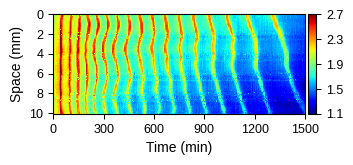

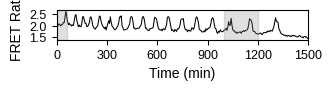

In [14]:
# Lower panel kymograph
# The space axis (also for 3C) might be inverted
dir_single = dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube4Ratio_Montage.tif']

extract_data_plt_new(10.79, dir_single, [300 * i for i in range(6)], flip=True, plot_crop=True, plot_traj=False, plot_cur=False, vmin=1.1, vmax=2.7, lengthticks=[0, 2, 4, 6, 8, 10])

ax = plt.gca()
set_size(ax, 2.5, 1)

plt.show()

# Upper panel FRET ratio timecourse
act = dir_single['Activity'][0,:300]

plt.plot(dir_single['t'][:300],act,'#A4C2A5',zorder=-10,linewidth=0.75,color='k')
plt.axvspan(0.0, 60.0, color='grey', alpha=0.25)
plt.axvspan(1000.0, 1200.0, color='grey', alpha=0.25)

plt.xlabel('Time (min)')
plt.ylabel('FRET Ratio')

plt.xlim([0,1500])
plt.xticks([300 * i for i in range(6)])
plt.yticks([1.5, 2, 2.5])

ax = plt.gca()
set_size(ax, 2.5, .3)

plt.show()

## Figure 1C, Spatial Profiles over Time

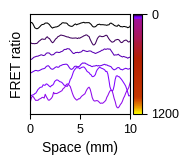

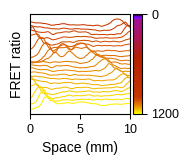

In [15]:
cmapname = 'gnuplot'
v1pos = 0.4
v2pos = 0.6

cmap = cmap_nonlin(mpl.cm.get_cmap(cmapname), [60 / 1200, v1pos], [1000 / 1200, v2pos])

img = io.imread('exp/030222 (Cdc25 Inhib)/Pos1 (0 uM no nuc)/Tube4Ratio_Montage.tif')
draw_spatial_profile(img, 10.79, 5.0, "1C-1.pdf", 0, 12, size=(1, 1), xticks=[0, 5, 10], ylim=[-1.25, 0.15], cmap=cmap, strt_c=0, end_c=240)
draw_spatial_profile(img, 10.79, 5.0, "1C-2.pdf", 200, 240, size=(1, 1), xticks=[0, 5, 10], cmap=cmap, strt_c=0, end_c=240)


## Figure 3A, Example Kymograph w/ Nuclei

- Lower section of the kymograph is cropped

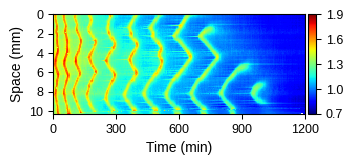

In [16]:
dir_single = dir_dd['exp']['032322 (Wee1 Inhib)']['Pos1 (0 uM nuc)']['Tube2Ratio_Montage.tif']

extract_data_plt_new(10.37, dir_single, [300 * i for i in range(5)], flip=True, plot_crop=True, plot_traj=False, plot_cur=False, vmin=0.7, vmax=1.9, lengthticks=[0, 2, 4, 6, 8, 10])

ax = plt.gca()
set_size(ax, 2.5, 1)

plt.show()


## Figure 3B, Spatial Profiles over Time

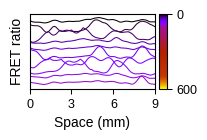

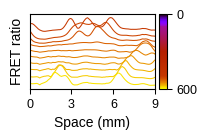

In [17]:
cmapname = 'gnuplot'
v1pos = 0.4
v2pos = 0.6

cmap = cmap_nonlin(mpl.cm.get_cmap(cmapname), [100 / 600, v1pos], [500 / 600, v2pos])

img = io.imread('exp/032322 (Wee1 Inhib)/Pos1 (0 uM nuc)/Tube2Ratio_Montage.tif')
draw_spatial_profile(img, 10.37, 5.0, "3B-1.pdf", 0, 20, xticks=[0, 3, 6, 9], size=(1.25, 0.75),strt_c=0, end_c=120, cmap=cmap)
draw_spatial_profile(img, 10.37, 5.0, "3B-2.pdf", 100, 120, xticks=[0, 3, 6, 9], size=(1.25, 0.75),strt_c=0, end_c=120, cmap=cmap)


# <b>Figures 1 and 3, Wave Speed and Period

## Figure 1D

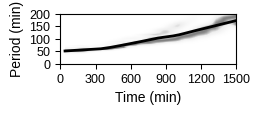

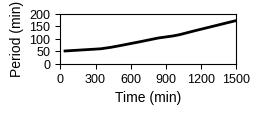

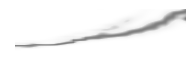

In [18]:
fig = plt.figure()
ax = plt.gca()
plot_kde(xx_T, yy_T, dens_T, wnx_T, wny_T, xticks=[300 * i for i in range(6)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, 1.75, 0.5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("1D-1.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_T, yy_T, dens_T, wnx_T, wny_T, xticks=[300 * i for i in range(6)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, 1.75, 0.5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("1D-1-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_T, yy_T, dens_T, wnx_T, wny_T, xticks=[300 * i for i in range(6)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, 1.75, 0.5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("1D-1.png", bbox_inches="tight")

writetocsv("1D-1.csv", wnx_T, wny_T)


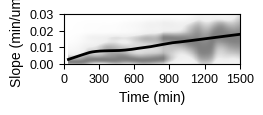

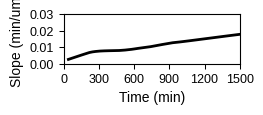

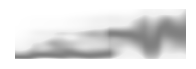

In [19]:
fig = plt.figure()
ax = plt.gca()
plot_kde(xx_S, yy_S, dens_S, wnx_S, wny_S, xticks=[300 * i for i in range(6)], yticks=[0.01 * i for i in range(4)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, 1.75, 0.5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("1D-2.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_S, yy_S, dens_S, wnx_S, wny_S, xticks=[300 * i for i in range(6)], yticks=[0.01 * i for i in range(4)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, 1.75, 0.5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("1D-2-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_S, yy_S, dens_S, wnx_S, wny_S, xticks=[300 * i for i in range(6)], yticks=[0.01 * i for i in range(4)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, 1.75, 0.5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("1D-2.png", bbox_inches="tight")

writetocsv("1D-2.csv", wnx_S, wny_S)

fitparams [525.67565625 209.71472089  44.25977597]
tau: 963.3945705552965-1010.4017081810498, b: 42.324157797740035-46.19539414840249
tau_0: 461.22248311745363, Delta tau: 525.6756562507195, v_ter: 44.259775973071264


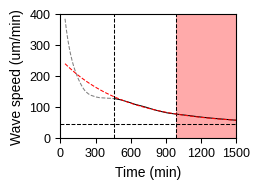

In [20]:
q = plot_speed(wnx_S, 1 / wny_S, err=wne_S / wny_S ** 2, size=(1.75, 1.25))
plt.savefig("1D-3.pdf", bbox_inches="tight")

print(f"tau_0: {q[0]}, Delta tau: {q[1] - q[0]}, v_ter: {q[2]}")

writetocsv("1D-3.csv", wnx_S, 1 / wny_S)



## Figure 1E

fitparams [525.67565625 209.71472089  44.25977597]
tau: 963.3945705552965-1010.4017081810498, b: 42.324157797740035-46.19539414840249
461.22248311745363 986.8981393681731
Markers at (mins):
40.446758929454, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0
51.301190260256355, 53.006460892381014, 55.88699061035458, 58.27169183118021, 63.53390471983367, 72.01334277037877, 80.9576296483482, 90.61055297185516, 100.59894106115142, 107.65045890098489, 115.31875062001934, 127.32091122536907, 139.0005364157776
383.10842224107495, 249.17829948217795, 156.59002985078575, 131.63671596193723, 127.10817126034462, 123.29848504332264, 112.3155205123362, 101.42576429484129, 90.1362216372583, 80.85046983940943, 75.58267334399937, 70.76862816474888, 66.34493587830296


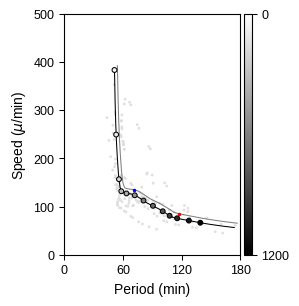

In [21]:
fig = plt.figure()
ax = plt.gca()
q = plot_speed(wnx_S, 1 / wny_S, err=wne_S / wny_S ** 2, plot=False)
t0 = q[0]
tau = q[1]
print(t0, tau)

plot_speed_period_relation(wny_T, wny_S, wnx_S, xticks=[0, 60, 120, 180], yticks=[0, 100, 200, 300, 400, 500], t0=t0, tau=tau, ghost_x_offset=3, ghost_y_offset=9, fig=fig, ax=ax, size=(1.75, 61.63/25.4),
                single=[
                    dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)'],
                    dir_dd['exp']['080421 (CSF_Cont)']['Pos1 (no nuc)'], # these are controls w/o csf
                ], )


plt.savefig("1E.pdf", bbox_inches="tight")
writetocsv("1E.csv", wnx_S, wny_T, 1 / wny_S)

## Figure 3C

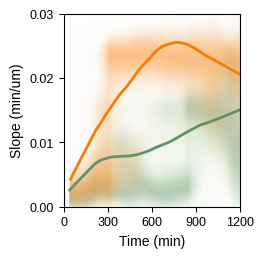

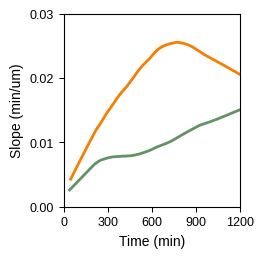

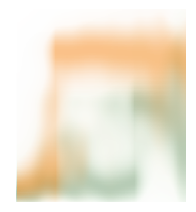

In [22]:
fig = plt.figure()
ax = plt.gca()
cmap = custom_colormap(['#FFFFFF00',"#B3E1B511", "#62936477"])
plot_kde(xx_S, yy_S, dens_S, wnx_S, wny_S, xticks=[300 * i for i in range(5)], yticks=[0.01 * i for i in range(4)], fit=False, fig=fig, ax=ax, draw_axis=True, cmap=cmap)
cmap = custom_colormap(['#FFFFFF00','#F7C38F11','#F77D0377'])
plot_kde(xx_n_S, yy_n_S, dens_n_S, wnx_n_S, wny_n_S, xticks=[300 * i for i in range(5)], yticks=[0.01 * i for i in range(4)], fit=False, fig=fig, ax=ax, col1="#F77D03", col2="#F7C38F", draw_axis=True, cmap=cmap)

set_size(ax, 1.75, 61.63/25.4 * 4 / 5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("3C.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
cmap = custom_colormap(['#FFFFFF00',"#B3E1B511", "#62936477"])
plot_kde(xx_S, yy_S, dens_S, wnx_S, wny_S, xticks=[300 * i for i in range(5)], yticks=[0.01 * i for i in range(4)], fit=False, fig=fig, ax=ax, draw_density=False, draw_axis=True, cmap=cmap)
cmap = custom_colormap(['#FFFFFF00','#F7C38F11','#F77D0377'])
plot_kde(xx_n_S, yy_n_S, dens_n_S, wnx_n_S, wny_n_S, xticks=[300 * i for i in range(5)], yticks=[0.01 * i for i in range(4)], fit=False, fig=fig, ax=ax, col1="#F77D03", col2="#F7C38F", draw_density=False, draw_axis=True, cmap=cmap)

set_size(ax, 1.75, 61.63/25.4 * 4 / 5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("3C-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
cmap = custom_colormap(['#FFFFFF00',"#B3E1B511", "#62936477"])
plot_kde(xx_S, yy_S, dens_S, wnx_S, wny_S, xticks=[300 * i for i in range(5)], yticks=[0.01 * i for i in range(4)], fit=False, fig=fig, ax=ax, draw_axis=False, cmap=cmap)
cmap = custom_colormap(['#FFFFFF00','#F7C38F11','#F77D0377'])
plot_kde(xx_n_S, yy_n_S, dens_n_S, wnx_n_S, wny_n_S, xticks=[300 * i for i in range(5)], yticks=[0.01 * i for i in range(4)], fit=False, fig=fig, ax=ax, col1="#F77D03", col2="#F7C38F", draw_axis=False, cmap=cmap)

set_size(ax, 1.75, 61.63/25.4 * 4 / 5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("3C.png", bbox_inches="tight")

writetocsv("3C.csv", wnx_n_S, wny_n_S)

## Figure 3D

fitparams [156.80152017 192.5182808   39.11216469]
tau: 270.3036587905528-273.2993815461909, b: 39.00851895818473-39.215810416890825
tau: 271.80152016837184, v_ter: 39.11216468753778


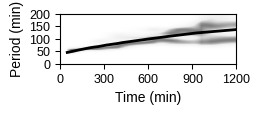

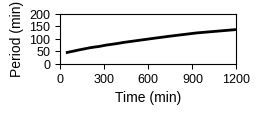

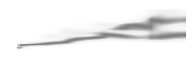

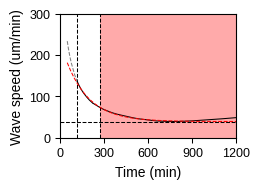

In [23]:
fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_T, yy_n_T, dens_n_T, wnx_n_T, wny_n_T, xticks=[300 * i for i in range(5)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, 1.75, 0.5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("3D-1.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_T, yy_n_T, dens_n_T, wnx_n_T, wny_n_T, xticks=[300 * i for i in range(5)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, 1.75, 0.5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("3D-1-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_T, yy_n_T, dens_n_T, wnx_n_T, wny_n_T, xticks=[300 * i for i in range(5)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, 1.75, 0.5)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("3D-1.png", bbox_inches="tight")

writetocsv("3D-1.csv", wnx_n_T, wny_n_T)

q = plot_speed(wnx_n_S, 1 / wny_n_S, err=wne_n_S / wny_n_S ** 2, size=(1.75, 1.25))
plt.xlim([0, 1200])
plt.ylim([0, 300])
plt.savefig("3D-2.pdf", bbox_inches="tight")

writetocsv("3D-2.csv", wnx_n_S, 1 / wny_n_S)

print(f"tau: {q[1]}, v_ter: {q[2]}")


## Figure 3E

fitparams [525.67565625 209.71472089  44.25977597]
tau: 963.3945705552965-1010.4017081810498, b: 42.324157797740035-46.19539414840249
Markers at (mins):
40.446758929454, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 1000.0, 1100.0, 1200.0
51.301190260256355, 53.006460892381014, 55.88699061035458, 58.27169183118021, 63.53390471983367, 72.01334277037877, 80.9576296483482, 90.61055297185516, 100.59894106115142, 107.65045890098489, 115.31875062001934, 127.32091122536907, 139.0005364157776
383.10842224107495, 249.17829948217795, 156.59002985078575, 131.63671596193723, 127.10817126034462, 123.29848504332264, 112.3155205123362, 101.42576429484129, 90.1362216372583, 80.85046983940943, 75.58267334399937, 70.76862816474888, 66.34493587830296
461.22248311745363 986.8981393681731
fitparams [156.80152017 192.5182808   39.11216469]
tau: 270.3036587905528-273.2993815461909, b: 39.00851895818473-39.215810416890825
Markers at (mins):
47.54360745530086, 100.00000000000001, 200.0, 300.0,

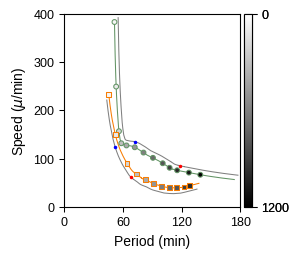

In [24]:
fig = plt.figure()
ax = plt.gca()
q = plot_speed(wnx_S, 1 / wny_S, err=wne_S / wny_S ** 2, plot=False)
t0 = q[0]
tau = q[1]
plot_speed_period_relation(wny_T, wny_S, wnx_S, xticks=[0, 60, 120, 180], yticks=[0, 100, 200, 300, 400], t0=t0, tau=tau, ghost_x_offset=3.75, ghost_y_offset=9, fig=fig, ax=ax, size=(1.75, 61.63/25.4 * 4 / 5), linecolor='#629364')
print(t0, tau)

q = plot_speed(wnx_n_S, 1 / wny_n_S, err=wne_n_S / wny_n_S ** 2, plot=False)
t0 = q[0]
tau = q[1]
plot_speed_period_relation(wny_n_T, wny_n_S, wnx_n_S, xticks=[0, 60, 120, 180], yticks=[0, 100, 200, 300, 400], t0=t0, tau=tau, ghost_x_offset=-2, ghost_y_offset=-12, fig=fig, ax=ax, size=(1.75, 61.63/25.4 * 4 / 5), linecolor='#F77D03', marker='s')
print(t0, tau)

plt.savefig("3E.pdf", bbox_inches="tight")
writetocsv("3E.csv", wnx_n_S, wny_n_T, 1 / wny_n_S)

# <b>Figure 5, Kymographs and Spatial Profiles</b>

## Figure 5B (Low Resolution)

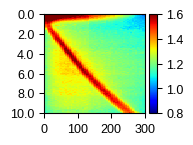

In [25]:
orig_image = io.imread('exp/112221_Pos5_Tube2_Ratio_New_Montage_TimeBinned.tif')
spc = 10.00

filled_cropped_image = orig_image
sz = np.shape(orig_image)

fig=plt.figure()
ax = plt.gca()
im=ax.pcolormesh(5.0*np.linspace(0,sz[1],sz[1]),spc*np.linspace(0,1,sz[0]),np.flipud(orig_image),cmap='jet',vmax=1.6,vmin=0.8)

plt.xlim(0, 300)
plt.xticks([100 * i for i in range(4)])
ax.set_yticks([max(plt.ylim()) - 10 + 2 * i for i in range(6)])

ax.set_yticklabels(["10.0", "8.0", "6.0", "4.0", "2.0", "0.0"])
set_size(ax, 5, 5)

pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.03, pos.y0, 0.025 * 2.5, pos.y1 - pos.y0])
fig.colorbar(
    mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=0.8, vmax=1.6), cmap='jet'),
    orientation='vertical',
    cax=cax,
    ticks=[0.8, 1, 1.2, 1.4, 1.6],
)

set_size(ax, 1, 1)

plt.show()



## Figure 5C

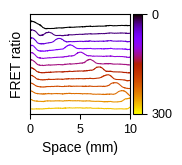

In [26]:
cmap = mpl.cm.get_cmap('gnuplot')

img = io.imread('exp/112221_Pos5_Tube2_Ratio_New_Montage_TimeBinned.tif')
draw_spatial_profile(img, 10.0, 5.0, "4C.pdf", 0, 60, size=(1, 1), xticks=[0, 5, 10], interval=5, cmap=cmap)


## Figure 5D (Low Resolution)

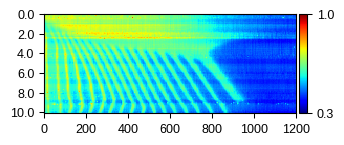

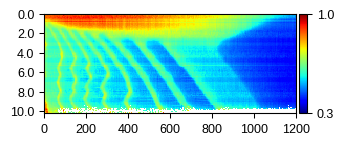

In [27]:
orig_image = io.imread('exp/080421 (CSF)/Pos2 (no nuc)/Tube2Ratio_Montage.tif')
filled_cropped_image = inpaint.inpaint_biharmonic(orig_image, np.isnan(orig_image))

fig = plt.figure()
ax = plt.gca()

ax.pcolormesh(np.flipud(filled_cropped_image),cmap='jet', vmin=0.3, vmax=1.0)

plt.xlim(0, 1200 / 5)
plt.xticks([40 * i for i in range(7)])
ax.set_xticklabels([200 * i for i in range(7)])
ax.set_yticks([max(plt.ylim()) - 100 + 20 * i for i in range(6)])
ax.set_yticklabels(["10.0", "8.0", "6.0", "4.0", "2.0", "0.0"])
set_size(ax, 2.5, 1)

pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.025, pos.y1 - pos.y0])
fig.colorbar(
    mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=0.3, vmax=1.0), cmap='jet'),
    orientation='vertical',
    cax=cax,
    ticks=[0.3, 1.0],
)

plt.show()

orig_image = io.imread('exp/080421 (CSF)/Pos6 (nuc)/Tube4Ratio_Montage.tif')
filled_cropped_image = inpaint.inpaint_biharmonic(orig_image, np.isnan(orig_image))

fig = plt.figure()
ax = plt.gca()

ax.pcolormesh(np.flipud(filled_cropped_image),cmap='jet', vmin=0.3, vmax=1.0)

plt.xlim(0, 1200 / 5)
plt.xticks([40 * i for i in range(7)])
ax.set_xticklabels([200 * i for i in range(7)])
ax.set_yticks([max(plt.ylim()) - 100 + 20 * i for i in range(6)])
ax.set_yticklabels(["10.0", "8.0", "6.0", "4.0", "2.0", "0.0"])
set_size(ax, 2.5, 1)

pos = ax.get_position()
cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.025, pos.y1 - pos.y0])
fig.colorbar(
    mpl.cm.ScalarMappable(mpl.colors.Normalize(vmin=0.3, vmax=1.0), cmap='jet'),
    orientation='vertical',
    cax=cax,
    ticks=[0.3, 1.0],
)

plt.show()


## Figure 5E

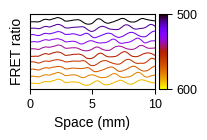

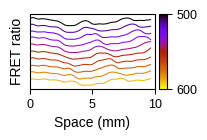

In [28]:
cmap = mpl.cm.get_cmap('gnuplot')

img = io.imread('exp/080421 (CSF)/Pos2 (no nuc)/Tube2Ratio_Montage.tif')
draw_spatial_profile(img, 10.4, 5.0, "4E1.pdf", 100, 120, size=(1.25, 0.75), xticks=[0, 5, 10], cmap=cmap)

plt.savefig("4E-1.pdf", bbox_inches="tight")

img = io.imread('exp/080421 (CSF)/Pos6 (nuc)/Tube4Ratio_Montage.tif')
length = img.shape[0]
# avoid nan

img = img[:94, :]
draw_spatial_profile(img, 10.44 * 94 / length, 5.0, "4E2.pdf", 100, 120, size=(1.25, 0.75), xticks=[0, 5, 10], cmap=cmap)

plt.savefig("4E-2.pdf", bbox_inches="tight")

# <b>Figure 5, Wave Speed and Period

## Figure 5F

fitparams [395.83919166  50.34752985  27.41180781]
tau: 536.0047705597202-547.7692174891564, b: 27.152985769814528-27.670629842699675
tau: 541.8869940244383, v_ter: 27.4118078062571
fitparams [ 80.76330175 138.20568378  30.75125885]
tau: 125.276051993667-126.25055149660842, b: 30.705675228208353-30.796842470723224
tau: 125.76330174513771, v_ter: 30.75125884946579


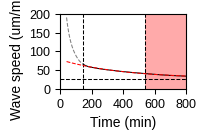

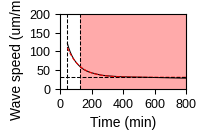

In [29]:
q = plot_speed(wnx_S_csf, 1 / wny_S_csf, err=wne_S_csf / wny_S_csf ** 2, size=(1.25, 0.75), yticks=[0, 50, 100, 150, 200], tticks=[0, 200, 400, 600, 800])
plt.savefig("4F-1.pdf", bbox_inches="tight")
writetocsv("4F-1.csv", wnx_S_csf, 1 / wny_S_csf)

print(f"tau: {q[1]}, v_ter: {q[2]}")

q = plot_speed(wnx_n_S_csf, 1 / wny_n_S_csf, err=wne_n_S_csf / wny_n_S_csf ** 2, size=(1.25, 0.75), yticks=[0, 50, 100, 150, 200], tticks=[0, 200, 400, 600, 800])
plt.savefig("4F-2.pdf", bbox_inches="tight")
writetocsv("4F-2.csv", wnx_n_S_csf, 1 / wny_n_S_csf)

print(f"tau: {q[1]}, v_ter: {q[2]}")

## Figure 5G

fitparams [395.83919166  50.34752985  27.41180781]
tau: 536.0047705597202-547.7692174891564, b: 27.152985769814528-27.670629842699675
Markers at (mins):
40.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0
55.81796582169855, 46.95406585606237, 40.025262361564266, 42.14873539212603, 45.47355998139734, 50.289574177297816, 55.913270935035, 62.54307209001576, 70.20600817822131, 78.00029760928902
191.23880539146685, 88.48765236494312, 57.31574590159333, 50.691255239711815, 45.90627038159335, 42.00893001804712, 38.5125770157931, 35.6532216303032, 33.78012323502598, 32.58194778877353
146.04780235951225 541.8869940244383
fitparams [ 80.76330175 138.20568378  30.75125885]
tau: 125.276051993667-126.25055149660842, b: 30.705675228208353-30.796842470723224
Markers at (mins):
45.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0
65.89887993565559, 63.87640906514746, 58.62420135570169, 62.879406188064834, 71.79279171286534, 81.58516740679221, 87.86986331395698, 90.29046384396676
122.0

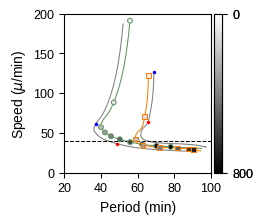

In [30]:
fig = plt.figure()
ax = plt.gca()

q = plot_speed(wnx_S_csf, 1 / wny_S_csf, err=wne_S_csf / wny_S_csf ** 2, plot=False)
t0 = q[0]
tau = q[1]
plot_speed_period_relation(wny_T_csf, wny_S_csf, wnx_S_csf, xticks=[20, 40, 60, 80, 100], yticks=[0, 50, 100, 150, 200], t0=t0, tau=tau, ghost_x_offset=-3.75, ghost_y_offset=-4, fig=fig, ax=ax, linecolor='#629364', vmax=800)
print(t0, tau)

q = plot_speed(wnx_n_S_csf, 1 / wny_n_S_csf, err=wne_n_S_csf / wny_n_S_csf ** 2, plot=False)
t0 = q[0]
tau = q[1]
plot_speed_period_relation(wny_n_T_csf, wny_n_S_csf, wnx_n_S_csf, xticks=[20, 40, 60, 80, 100], yticks=[0, 50, 100, 150, 200], t0=t0, tau=tau, ghost_x_offset=3, ghost_y_offset=5, fig=fig, ax=ax, linecolor='#F77D03', vmax=800, marker='s')
print(t0, tau)

ax.plot([20, 100], [40, 40], 'k--', linewidth=0.75)

plt.savefig("4G.pdf", bbox_inches="tight")

writetocsv("4G-1.csv", wnx_S_csf, wny_T_csf, 1 / wny_S_csf)
writetocsv("4G-2.csv", wnx_n_S_csf, wny_n_T_csf, 1 / wny_n_S_csf)

# <b>Figure 7</b>

In [31]:
q1, e1 = plot_speed(wnx_S, 1 / wny_S, err=wne_S / wny_S ** 2, plot=False, return_err=True)
q2, e2 = plot_speed(wnx_n_S, 1 / wny_n_S, err=wne_n_S / wny_n_S ** 2, plot=False, return_err=True)
q3, e3 = plot_speed(wnx_S_csf, 1 / wny_S_csf, err=wne_S_csf / wny_S_csf ** 2, plot=False, return_err=True)
q4, e4 = plot_speed(wnx_n_S_csf, 1 / wny_n_S_csf, err=wne_n_S_csf / wny_n_S_csf ** 2, plot=False, return_err=True)

print(q1[0], q1[1] - q1[0], q1[2])
print(q2[0], q2[1] - q2[0], q2[2])
print(q3[0], q3[1] - q3[0], q3[2])
print(q4[0], q4[1] - q4[0], q4[2])


fitparams [525.67565625 209.71472089  44.25977597]
tau: 963.3945705552965-1010.4017081810498, b: 42.324157797740035-46.19539414840249
fitparams [156.80152017 192.5182808   39.11216469]
tau: 270.3036587905528-273.2993815461909, b: 39.00851895818473-39.215810416890825
fitparams [395.83919166  50.34752985  27.41180781]
tau: 536.0047705597202-547.7692174891564, b: 27.152985769814528-27.670629842699675
fitparams [ 80.76330175 138.20568378  30.75125885]
tau: 125.276051993667-126.25055149660842, b: 30.705675228208353-30.796842470723224
461.22248311745363 525.6756562507195 44.259775973071264
115.00000000000004 156.80152016837178 39.11216468753778
146.04780235951225 395.83919166492603 27.4118078062571
45.0 80.76330174513771 30.75125884946579


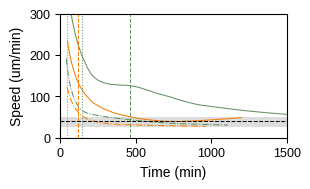

In [32]:
fig = plt.figure()
ax = plt.gca()

cmap = mpl.cm.get_cmap("Paired")

ax.fill_between([0, 1500], [25, 25], [50, 50], facecolor="#dddddd")

ax.plot(wnx_S, 1 / wny_S, linewidth=0.75, color='#629364')
ax.plot([q1[0], q1[0]], [0, 300], '--', linewidth=0.75, color='#629364')
ax.plot(wnx_n_S, 1 / wny_n_S, linewidth=0.75, color='#F77D03')
ax.plot([q2[0], q2[0]], [0, 300], '--', linewidth=0.75, color='#F77D03')
ax.plot(wnx_S_csf, 1 / wny_S_csf, '-.', linewidth=0.75, color='#629364')
ax.plot([q3[0], q3[0]], [0, 300], ':', linewidth=0.75, color='#629364')
ax.plot(wnx_n_S_csf, 1 / wny_n_S_csf, '-.', linewidth=0.75, color='#F77D03')
ax.plot([q4[0], q4[0]], [0, 300], ':', linewidth=0.75, color='#F77D03')

ax.plot([0, 1500], [40, 40], 'k--', linewidth=0.75)

ax.set_xlim([0, 1500])
ax.set_ylim([0, 300])
set_size(ax, 2.25, 1.25)
ax.set_xticks([0, 500, 1000, 1500])

ax.set_xlabel("Time (min)")
ax.set_ylabel("Speed (um/min)")

plt.savefig("6A.pdf", bbox_inches="tight")


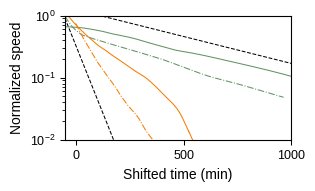

In [33]:
fig = plt.figure()
ax = plt.gca()

cmap = mpl.cm.get_cmap("Paired")

ax.plot(np.linspace(0, 1000), np.exp(-1 / 500 * np.linspace(0, 1000)) * 1.25, 'k--', linewidth=0.75)
ax.plot(np.linspace(-50, 1000), np.exp(-1 / 50 * np.linspace(-50, 1000)) / 3, 'k--', linewidth=0.75)

v0 = 1 / wny_S[np.argmin(np.abs(wnx_S - q1[0]))]
x = wnx_S - q1[0]
y = (1 / wny_S - q1[2]) / v0
ax.plot(x, y, linewidth=0.75, color='#629364')

writetocsv("6B-1.csv", x, y)

v0 = 1 / wny_n_S[np.argmin(np.abs(wnx_n_S - q2[0]))]
x = wnx_n_S - q2[0]
y = (1 / wny_n_S - q2[2]) / v0
y = y[x < 750]
x = x[x < 750]
ax.plot(x, y, linewidth=0.75, color='#F77D03')

writetocsv("6B-2.csv", x, y)

v0 = 1 / wny_S_csf[np.argmin(np.abs(wnx_S_csf - q3[0]))]
x = wnx_S_csf - q3[0]
y = (1 / wny_S_csf - q3[2]) / v0
ax.plot(x, y, '-.', linewidth=0.75, color='#629364')

writetocsv("6B-3.csv", x, y)

v0 = 1 / wny_n_S_csf[np.argmin(np.abs(wnx_n_S_csf - q4[0]))]
x = wnx_n_S_csf - q4[0]
y = (1 / wny_n_S_csf - q4[2]) / v0
ax.plot(x, y, '-.', linewidth=0.75, color='#F77D03')

writetocsv("6B-4.csv", x, y)

ax.set_yscale('log')
ax.set_xlim([-50, 1000])
ax.set_ylim([0.01, 1])
set_size(ax, 2.25, 1.25)
ax.set_xticks([0, 500, 1000])

ax.set_xlabel("Shifted time (min)")
ax.set_ylabel("Normalized speed")

plt.savefig("6B.pdf", bbox_inches="tight")


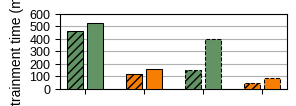

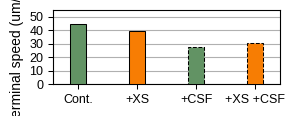

In [34]:
fig = plt.figure()
ax = plt.gca()

cmap = mpl.cm.get_cmap("Paired")

ax.bar([0, 3], [q1[0], q2[0]], color=["#629364", "#F77D03"], linestyle='-', edgecolor='k', linewidth=0.75, hatch='////', zorder=10)
ax.bar([6, 9], [q3[0], q4[0]], color=["#629364", "#F77D03"], linestyle='--', edgecolor='k', linewidth=0.75, hatch='////', zorder=10)
#ax.bar([0, 1.5], [q1[1] - q1[0], q2[1] - q2[0]], color=["#629364", "#F77D03"], linestyle='-', edgecolor='k', linewidth=0.75, bottom=[q1[0], q2[0]], yerr=[e1[0], e2[0]], zorder=10)
#ax.bar([3, 4.5], [q3[1] - q3[0], q4[1] - q4[0]], color=["#629364", "#F77D03"], linestyle='-.', edgecolor='k', linewidth=0.75, bottom=[q3[0], q4[0]], yerr=[e3[0], e4[0]], zorder=10)
ax.bar([1, 4], [q1[1] - q1[0], q2[1] - q2[0]], color=["#629364", "#F77D03"], linestyle='-', edgecolor='k', linewidth=0.75, zorder=10)
ax.bar([7, 10], [q3[1] - q3[0], q4[1] - q4[0]], color=["#629364", "#F77D03"], linestyle='--', edgecolor='k', linewidth=0.75, zorder=10)
ax.set_xticks([1.5 * i for i in range(4)])
ax.set_yticks([0, 100, 200, 300, 400, 500, 600])
ax.set_ylim([0, 600])
ax.set_xticklabels(["Cont.", "+XS", "+CSF", "+XS +CSF"])
ax.set_ylabel("Entrainment time (min)")
ax.grid(axis='y', zorder=0)
ax.set_xlim(-0.75, 10.75)
ax.set_xticks([0.5, 3.5, 6.5, 9.5])

set_size(ax, 2.25, 0.75)
plt.savefig("6C.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()

ax.set_ylim([0, 55])
ax.set_yticks([0, 10, 20, 30, 40, 50])
ax.bar([0.5, 3.5], [q1[2], q2[2]], color=["#629364", "#F77D03"], linestyle='-', edgecolor='k', linewidth=0.75, zorder=10)
ax.bar([6.5, 9.5], [q3[2], q4[2]], color=["#629364", "#F77D03"], linestyle='--', edgecolor='k', linewidth=0.75, zorder=10)
ax.set_xticklabels(["Cont.", "+XS", "+CSF", "+XS +CSF"])
ax.set_ylabel("Terminal speed (um/min)")
ax.grid(axis='y', zorder=0)
ax.set_xlim(-0.75, 10.75)
ax.set_xticks([0.5, 3.5, 6.5, 9.5])

set_size(ax, 2.25, 0.75)
plt.savefig("6D.pdf", bbox_inches="tight")

# <b>Figure 2</b>

## Figure 2B, Example Kymograph

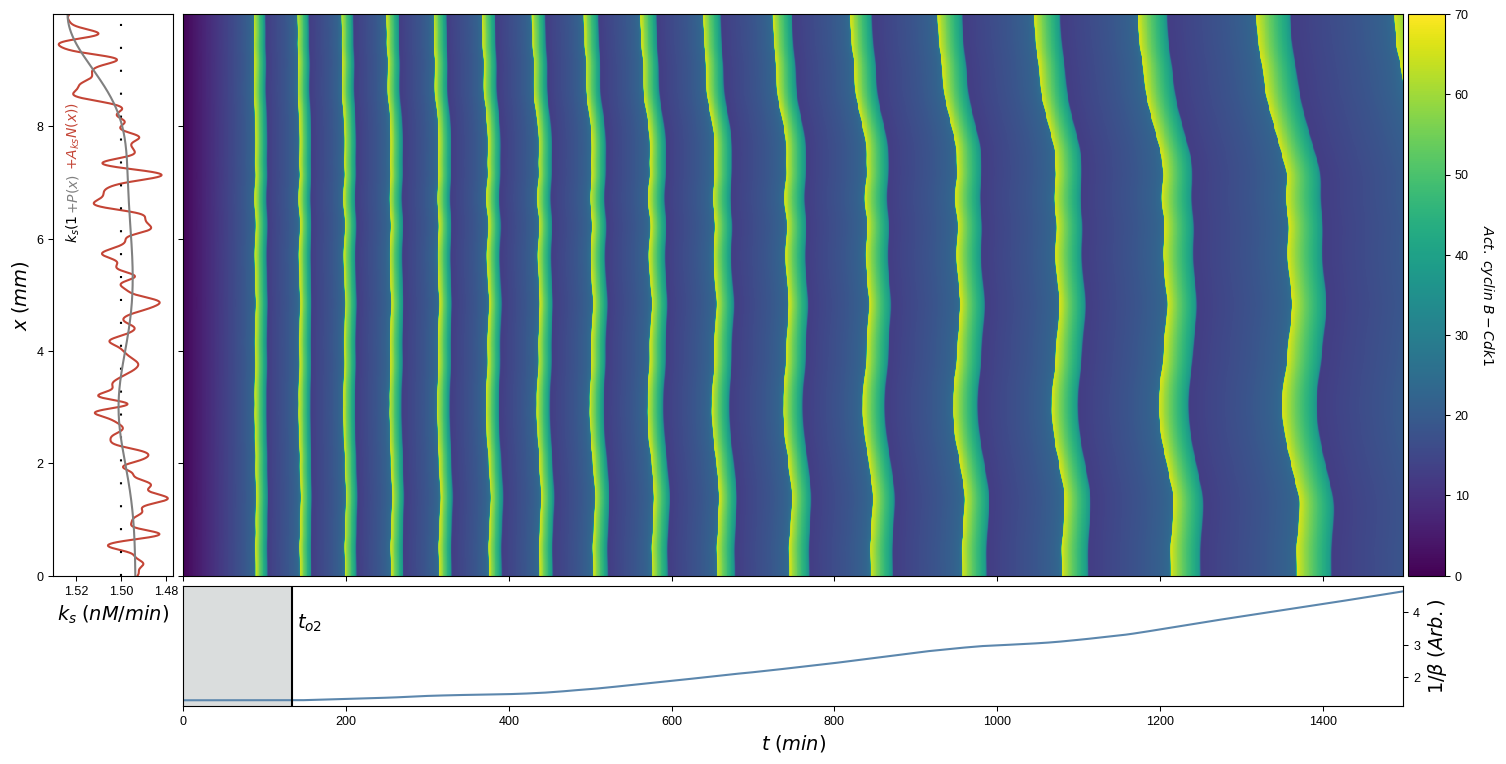

In [35]:
size = 7
fig = plt.figure(figsize=(2*size,size),constrained_layout=True)
ax = plt.subplot2grid((1, 1), (0, 0), colspan=60)

folder = 'sim/mit-waves12/'
plot_kymo_figure2(ax,folder,chi,133.5133513351335,colormap='viridis')

plt.savefig("2B.pdf", bbox_inches="tight")

## Figure 2C, Example Kymographs

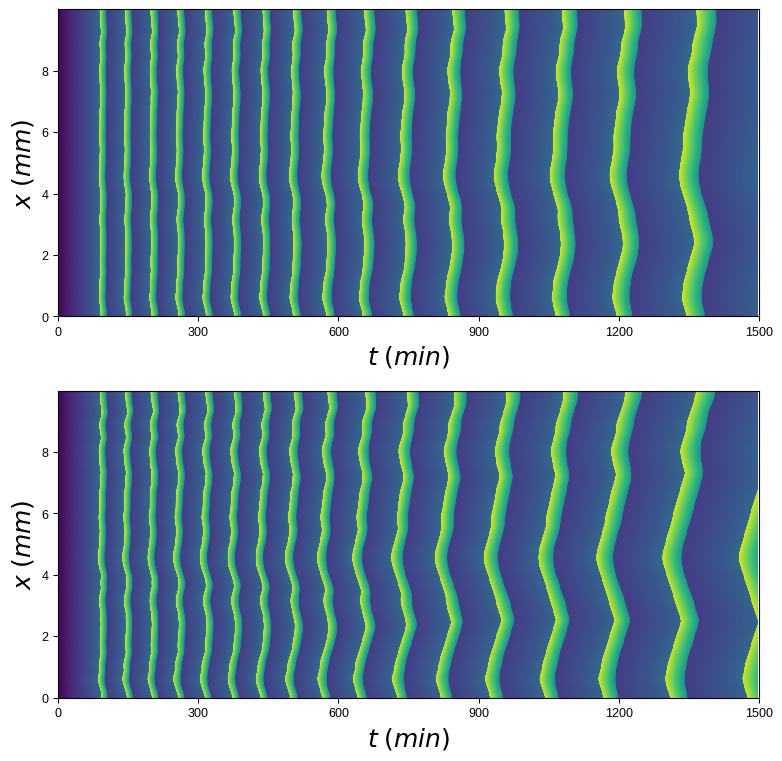

In [36]:
size = 5
fig = plt.figure(figsize=(2*1.5*size,1.5*size),constrained_layout=True)
ax = [None,None]
ax[0] = plt.subplot2grid((100, 100), (0, 0), rowspan=49, colspan=49)
ax[1] = plt.subplot2grid((100, 100), (51, 0), rowspan=49, colspan=49)
folders = ['sim/mit-waves17/','sim/mit-waves18/']
waves_id = ['None','None']

cols =['#629362','#e27e12','#5c87ad','#cf3a82','#99569f']

cmap = cmap_nonlin(mpl.cm.get_cmap('gray_r'), [5/7, 0], [5/7, 1])

for i,el in enumerate(folders):
    plot_simple_kymo(ax[i],el,chi,plot_traj = waves_id[i],color = cols[i],colormap='viridis')

ax[0].set_xlim([0, 1500])
ax[0].set_xticks([0, 300, 600, 900, 1200, 1500])
ax[1].set_xlim([0, 1500])
ax[1].set_xticks([0, 300, 600, 900, 1200, 1500])


plt.savefig("2C.pdf", bbox_inches="tight")


## Figure 2D, Dispersion Relation

fitparams [673.19273164 626.82157633 162.21823296]
tau: 1414.5033943103163-1418.229702115566, b: 161.86217993272712-162.57428599712298
fitparams [622.68890653 275.78552959  84.07168397]
tau: 1276.6707026924248-1281.856981057883, b: 83.8449727892254-84.29839515643671
fitparams [481.61015586 196.32824269  69.3694875 ]
tau: 1058.4341650048195-1062.2860619523703, b: 69.25956065491823-69.47941435057444
fitparams [365.43276056 140.98623845  56.80873419]
tau: 512.3225123797649-512.9652107635018, b: 56.78390414786791-56.833564232283514
fitparams [525.67565625 209.71472089  44.25977597]
tau: 963.3945705552965-1010.4017081810498, b: 42.324157797740035-46.19539414840249


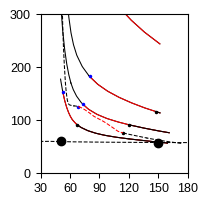

In [37]:
d_f2 = np.load('sim/data_fig2.npz')

fig = plt.figure()
ax = plt.gca()

for i in [1, 2, 3, 5]:
    t = dat_aks_t[i]
    s = dat_aks_s[i]
    p = dat_aks_p[i]

    q = plot_speed(t, s, plot=False, min_fraction=0)
    # min_fraction = 0 for simulations
    t0 = q[0]
    tau = q[1]

    ax.plot(p, s, 'k', linewidth=0.75)
    ax.plot(p[t >= t0], s[t >= t0], 'r', linewidth=0.75)
    ax.plot(p[t >= tau], s[t >= tau], 'k', linewidth=0.75)

    try:
        ax.plot(p[t >= t0][0], s[t >= t0][0], 'b.', markersize=3)
    except IndexError:
        ...

    try:
        ax.plot(p[t >= tau][0], s[t >= tau][0], 'k.', markersize=3)
    except IndexError:
        ...

t = wnx_S
s = 1 / wny_S
p = wny_T

q = plot_speed(wnx_S, 1 / wny_S, err=wne_S / wny_S ** 2, plot=False)
t0 = q[0]
tau = q[1]

if np.min(np.abs(t - t0)) < 1:
    idx = np.argmin(np.abs(t - t0))
    ax.plot(p[idx], s[idx], 'b.', markersize=3)

if np.min(np.abs(t - tau)) < 1:
    idx = np.argmin(np.abs(t - tau))
    ax.plot(p[idx], s[idx], 'k.', markersize=3)

ax.plot(p[t <= t0], s[t <= t0], 'k--', linewidth=0.75)
ax.plot(p[np.logical_and(t > t0, t <= tau)], s[np.logical_and(t > t0, t <= tau)], 'r--', linewidth=0.75)
ax.plot(p[t >= tau], s[t >= tau], 'k--', linewidth=0.75)

ax.plot(d_f2['period_dr'],d_f2['speed_dr'],c='k',label=r'$Dispersion$ $relation$',linestyle='dashed', linewidth=0.75)
ax.plot(d_f2['period_high'], d_f2['speed_high'],'o',c='k',linewidth=0.75)
ax.plot(d_f2['period_small'], d_f2['speed_small'],'o',c='k',linewidth=0.75)

ax.set_xlim([30, 180])
ax.set_xticks([30, 60, 90, 120, 150, 180])

ax.set_ylim([0, 300])
ax.set_yticks([0, 100, 200, 300])

set_size(ax, 1.75 * 5 / 6, 2 * 4 / 5)

plt.savefig("2D.pdf", bbox_inches='tight')

## Figure 2E

fitparams [673.19273164 626.82157633 162.21823296]
tau: 1414.5033943103163-1418.229702115566, b: 161.86217993272712-162.57428599712298
fitparams [622.68890653 275.78552959  84.07168397]
tau: 1276.6707026924248-1281.856981057883, b: 83.8449727892254-84.29839515643671
fitparams [481.61015586 196.32824269  69.3694875 ]
tau: 1058.4341650048195-1062.2860619523703, b: 69.25956065491823-69.47941435057444
fitparams [378.35666153 184.52168462  61.90039262]
tau: 579.1640132112237-579.7956733951779, b: 61.871475921064835-61.92930932543825
fitparams [365.43276056 140.98623845  56.80873419]
tau: 512.3225123797649-512.9652107635018, b: 56.78390414786791-56.833564232283514
fitparams [350.84738798 112.76852188  53.90558425]
tau: 444.98993455338103-445.60768817397496, b: 53.88441013745573-53.92675835628468
fitparams [335.00064012  94.79552589  51.94294612]
tau: 418.4602905635465-419.01941823860733, b: 51.92477140033253-51.96112083671636
fitparams [328.84130608  79.27134937  50.51372703]
tau: 411.473222

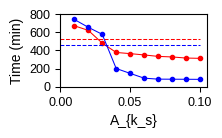

In [38]:
x = np.linspace(0.01, 0.1, 10)
y = np.zeros_like(x)
y2 = np.zeros_like(x)

for i in range(1, 11):
    t = dat_aks_t[i]
    s = dat_aks_s[i]
    p = dat_aks_p[i]

    q = plot_speed(t, s, plot=False)
    tau = q[1] - q[0]

    y[i - 1] = tau
    y2[i - 1] = q[0]

q = plot_speed(wnx_S, 1 / wny_S, err=wne_S / wny_S ** 2, plot=False)

fig = plt.figure()
ax = plt.gca()

ax.plot(x, y, 'r.-', linewidth=0.75)
ax.plot(x, y2, 'b.-', linewidth=0.75)
ax.plot([0, 0.1], [q[1] - q[0], q[1] - q[0]], 'r--', linewidth=0.75)
ax.plot([0, 0.1], [q[0], q[0]], 'b--', linewidth=0.75)

set_size(ax, 1.75 * 5 / 6, 1.75 * 5 / 6 / 2)
ax.set_xlim([0, 0.105])
ax.set_ylim([0, 800])
ax.set_yticks([0, 200, 400, 600, 800])

ax.set_xlabel("A_{k_s}")
ax.set_ylabel("Time (min)")

plt.savefig("2E.pdf", bbox_inches="tight")


# <b>Figure 4 </b>

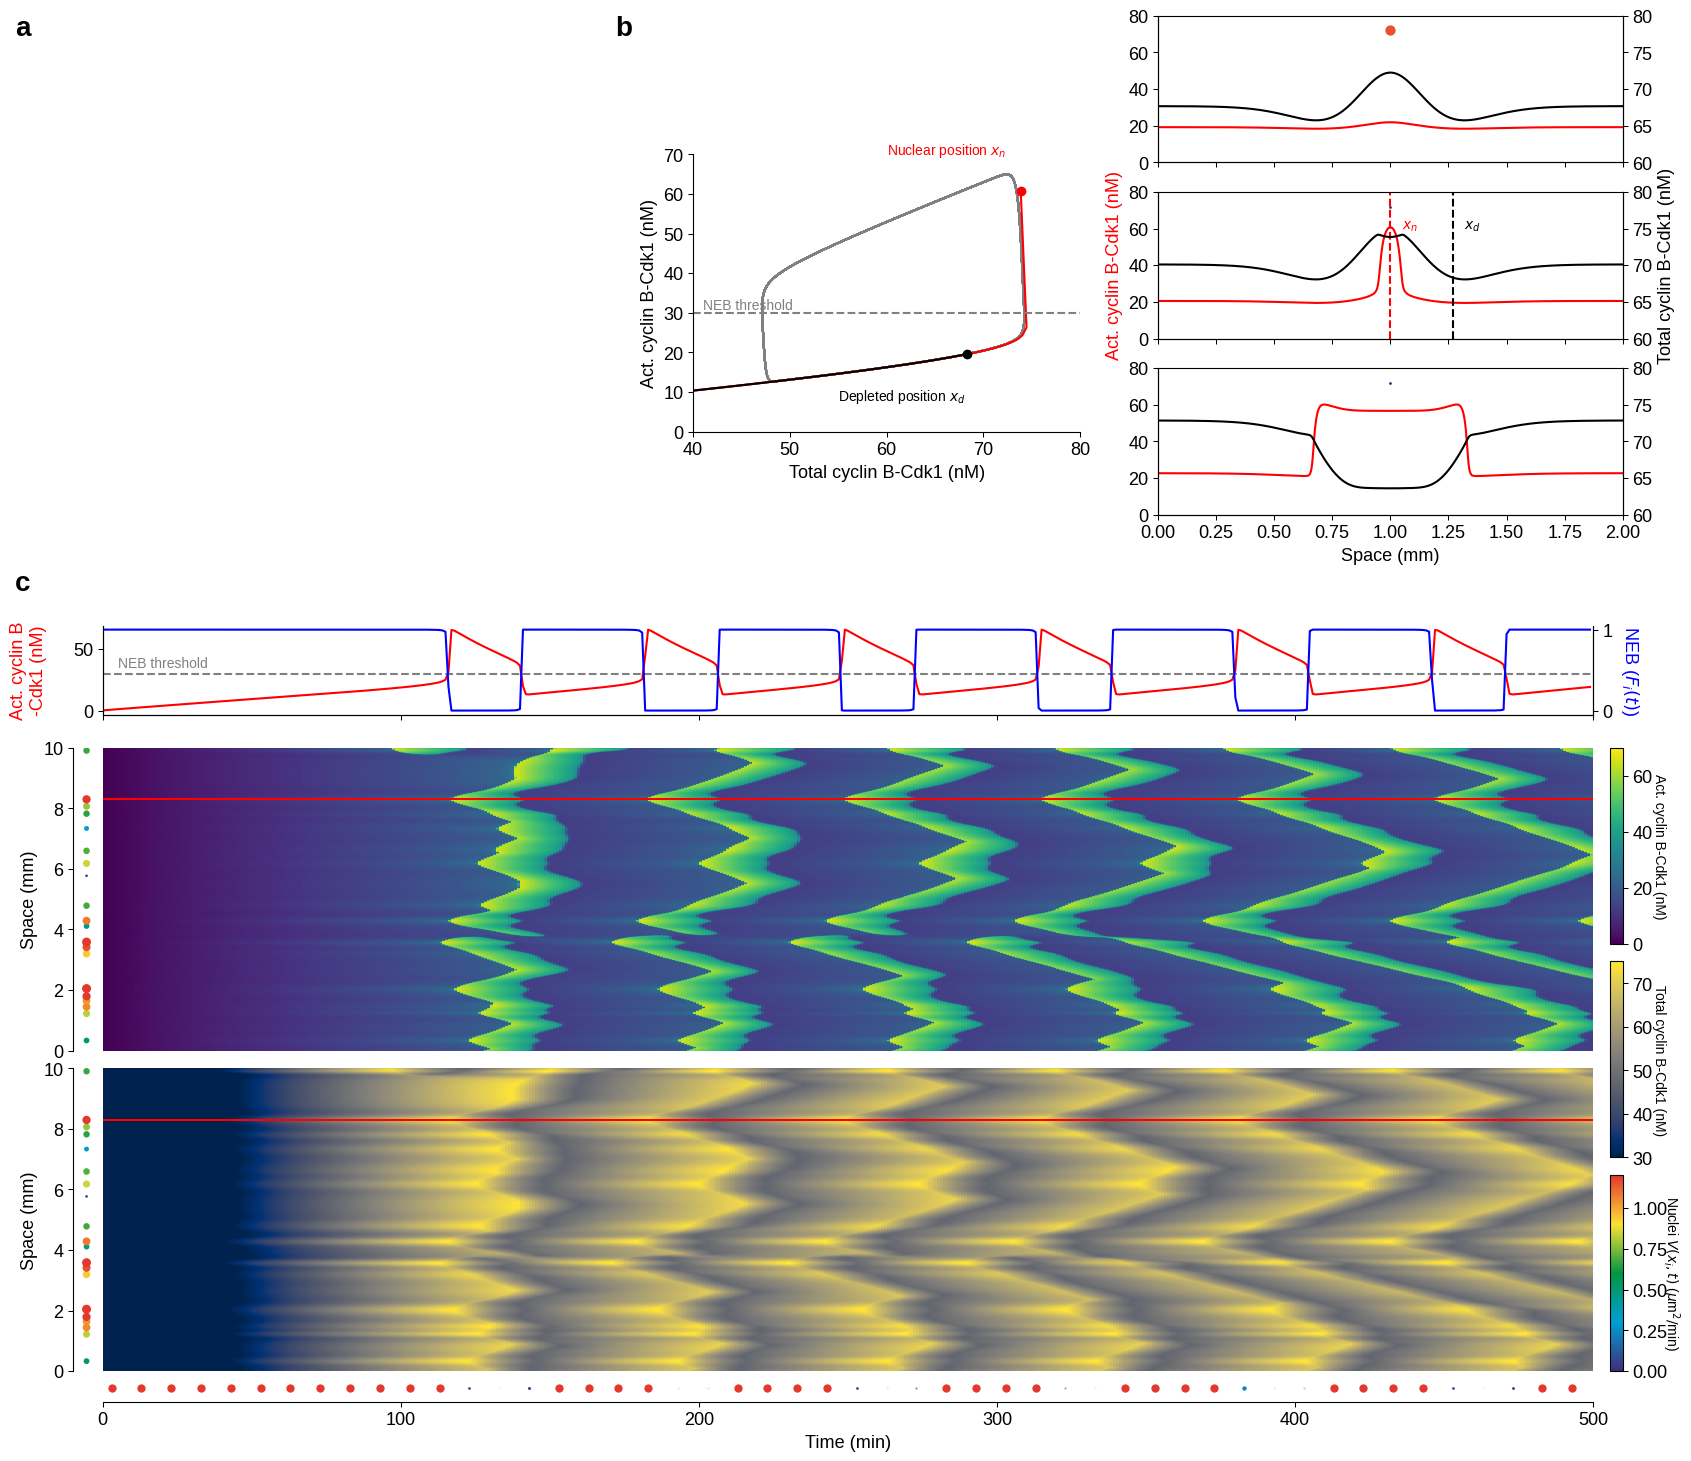

In [39]:
folder = 'sim/multiple-nuclei-4/'
dims = {'n':4096,'m':2}

fs = 13
fs1 = 10
plt.rcParams.update({"xtick.labelsize" : 13,
"ytick.labelsize" : 13,"axes.labelsize" : 13})

phi_a, phi_i = nuc.import_evolution(folder)
x, y, t = nuc.create_spacetime(folder)
tt1 = writen_time_array_plus_one(folder)


size = 1.
fig = plt.figure(figsize=(20*size,18*size))
gs0 = fig.add_gridspec(100, 100, wspace=0, hspace=0)
gs01 = gs0[44:,0:].subgridspec(51,104)
gs03 = gs0[10:30,40:65].subgridspec(1,1)
gs02 = gs0[0:36,70:].subgridspec(3,1)
colormap = color_scale()

x_i, eps_i, s_i = nuc.import_nuclei_params(folder)
params,nuclear_params,integration_params,init_params, =  nuc.import_param_sim(folder)

i_i = (x_i/integration_params['delta_x']).astype(int) + 1
ii = i_i[18]

axi_a = fig.add_subplot(gs01[8:28,2:102])
axi_c = fig.add_subplot(gs01[29:49,2:102])

for el in [axi_a,axi_c]:
    el.axhline(x[ii]*chi,c='red')

im0 = axi_a.pcolormesh(t,x*chi,phi_a[:,0,:].T, vmin=0, vmax=70,rasterized=True)
im01 = axi_c.pcolormesh(t,x*chi,(phi_a[:,0,:]+phi_i[:,0,:]).T,cmap='cividis', vmin=30, vmax=75,rasterized=True)

for axi in fig.get_axes():
    axi.axis('off')

axi_n = fig.add_subplot(gs01[8:28,0:2])
axi_n1 = fig.add_subplot(gs01[29:49,0:2])
for axi_ni in [axi_n,axi_n1]:
    v = nuc.nuclei_field_v(x, phi_a[0], x_i, eps_i, s_i, nuclear_params['ec50_neb'], nuclear_params['n_neb'])
    im02 = axi_ni.scatter(y[-1]/2+np.zeros(len(x_i)),x_i*chi, s=-v[i_i]*20*size, c=-v[i_i], vmin=0, vmax=1.2, cmap=colormap,marker='o')
    axi_ni.spines[['right', 'bottom', 'top']].set_visible(False)
    axi_ni.axes.get_xaxis().set_visible(False)
    axi_ni.set_ylabel('Space (mm)')
    axi_ni.set_ylim(0,10)

ax1 = fig.add_subplot(gs01[0:6,2:102])
ax1t = ax1.twinx()
ax1t.plot(t, nuc.f_i(phi_a[:,0,ii],nuclear_params['ec50_neb'], nuclear_params['n_neb']),c='blue')#'#4478F8')
ax1.plot(t, phi_a[:,0,ii],c='red')
ax1.axhline(30,c='gray',linestyle='dashed')
ax1.text(5,35,'NEB threshold',color='gray')
ax1.set_xlim(0,500)
ax1.axes.xaxis.set_ticklabels([])

ax1.set_ylabel('Act. cyclin B\n-Cdk1 (nM)',color='red',labelpad=19)
ax1t.set_ylabel('NEB ($F_i(t)$)',color='blue', rotation=270,labelpad=20)
ax1.spines[['top']].set_visible(False)
ax1t.spines[['top']].set_visible(False)

ax3 = fig.add_subplot(gs01[8:21,103:104])
cbar = plt.colorbar(im0, cax=ax3, orientation='vertical')
cbar.set_label('Act. cyclin B-Cdk1 (nM)', rotation=270,labelpad=10,fontsize=fs1,loc='center')
ax4 = fig.add_subplot(gs01[22:35,103:104])
cbar1 = plt.colorbar(im01, cax=ax4, orientation='vertical')
cbar1.set_label('Total cyclin B-Cdk1 (nM)', rotation=270,labelpad=10,fontsize=fs1,loc='center')
ax5 = fig.add_subplot(gs01[36:49,103:104])
cbar2 = plt.colorbar(im02, cax=ax5, orientation='vertical')
cbar2.set_label('Nuclei $V(x_i,t)$ ($\mu$m$^2/$min)', rotation=270,labelpad=10,fontsize=fs1,loc='center')

ax2 = fig.add_subplot(gs01[49:,2:102])
for i in range(0,100,2):
    i_t = i*5
    v = nuc.nuclei_field_v(x, phi_a[i_t], x_i, eps_i, s_i, nuclear_params['ec50_neb'], nuclear_params['n_neb'])
    ax2.scatter(t[i_t]+3,0, s=-v[ii]*20*size, c=-v[ii], vmin=0, vmax=1.2, cmap=colormap,marker='o')
ax2.spines[['top','left','right']].set_visible(False)
ax2.set_xlim(0,500)
ax2.axes.get_yaxis().set_visible(False)

ax2.set_xlabel('Time (min)')

# for el in [axi_n,ax1,ax1t,ax3,ax4,ax5]:
#     el.tick_params(axis='both', which='minor', labelsize=fs)

#---------

folder = 'sim/one-nuclei-2/'

phi_a, phi_i = nuc.import_evolution(folder)
x, y, t = nuc.create_spacetime(folder)
tt1 = writen_time_array_plus_one(folder)



colormap = color_scale()

ix = 110
x_i, eps_i, s_i = nuc.import_nuclei_params(folder)
params,nuclear_params,integration_params,init_params, =  nuc.import_param_sim(folder)
x0,x1 = 4,6
for i, i_t in enumerate([120, 126, 133]):
    ax = fig.add_subplot(gs02[i:i+1])
    axt = ax.twinx()

    v = nuc.nuclei_field_v(x, phi_a[i_t], x_i, eps_i, s_i, nuclear_params['ec50_neb'], nuclear_params['n_neb'])
    i_i = (x_i/integration_params['delta_x']).astype(int) + 1

    im1, = ax.plot(x*chi-x0,phi_a[i_t,0,:],c='red')
    im02 = ax.scatter(x_i*chi-x0, 72+np.zeros(len(x_i)), s=-v[i_i]*80+1, c=-v[i_i], vmin=0, vmax=0.52, cmap=colormap,marker='o')

    im11, = axt.plot(x*chi-x0,phi_a[i_t,0,:]+phi_i[i_t,0,:],c='black')
    ax.set_ylim(0,80)
    axt.set_ylim(60,80)
    ax.spines[['top']].set_visible(False)
    ax.set_xlim(0,x1-x0)
    if i !=2:
        ax.axes.xaxis.set_ticklabels([])


    if i == 1:
        ax.set_ylabel('Act. cyclin B-Cdk1 (nM)',color='red')
        axt.set_ylabel('Total cyclin B-Cdk1 (nM)',color='black')
    if i == 1:
        ax.axvline(x[dims['n']//2]*chi-x0,color='red',linestyle='dashed')
        ax.axvline(x[dims['n']//2+ix]*chi-x0,color='black',linestyle='dashed')
        ax.text(x[dims['n']//2]*chi-x0+0.05,60,'$x_n$',color='red')
        ax.text(x[dims['n']//2+ix]*chi-x0+0.05,60,'$x_d$',color='black')

ax.set_xlabel('Space (mm)')
ax.tick_params(axis='x',labelsize=fs)
ax.xaxis.label.set_size(fs)

ax = fig.add_subplot(gs03[0,0])

i_t_f = 126

# i_t_c = 200
# ax.plot(phi_a[:i_t_c,0,dims['n']//2]+phi_i[:i_t_c,0,dims['n']//2], phi_a[:i_t_c,0,dims['n']//2], c='gray')
p_0 = {'ks':1.5,
       'a_cdc25':0.8, 'b_cdc25':4, 'ec50_cdc25':35, 'n_cdc25':11,
       'a_wee1':0.4, 'b_wee1':2, 'ec50_wee1':30, 'n_wee1':3.5,
       'a_deg':0.01, 'b_deg':0.06, 'ec50_deg':32, 'n_deg':17,
       'Da':1,'Di':1,'tau':1,'alpha':1,'beta':0.5}

in_0 = chang2013model(p_0)
in_0.tf_timeseries = 1000
in_0.nt_timeseries = 10000
in_0.plot_phaseplane(ax)

ax.plot(phi_a[:i_t_f+1,0,dims['n']//2]+phi_i[:i_t_f+1,0,dims['n']//2], phi_a[:i_t_f+1,0,dims['n']//2], c='red')
ax.plot(phi_a[:i_t_f+1,0,dims['n']//2+ix]+phi_i[:i_t_f+1,0,dims['n']//2+ix], phi_a[:i_t_f+1,0,dims['n']//2+ix],c='black')

ax.plot(phi_a[i_t_f,0,dims['n']//2]+phi_i[i_t_f,0,dims['n']//2], phi_a[i_t_f,0,dims['n']//2], 'o',c='red')
ax.plot(phi_a[i_t_f,0,dims['n']//2+ix]+phi_i[i_t_f,0,dims['n']//2+ix], phi_a[i_t_f,0,dims['n']//2+ix],'o',c='black')

ax.text(60,70,'Nuclear position $x_n$',color='red')
ax.text(55,8,'Depleted position $x_d$',color='black')
ax.text(41,31,'NEB threshold',color='gray')

ax.set_ylabel('Act. cyclin B-Cdk1 (nM)',color='black')
ax.set_xlabel('Total cyclin B-Cdk1 (nM)',color='black')
ax.set_xlim(40,80)
ax.set_ylim(00,70)
ax.axhline(30,c='gray',linestyle='dashed')
ax.spines[['top','right']].set_visible(False)

fs0 = 20
ax.text(32,100,'b',color='black',fontweight="bold",fontsize=fs0)
ax.text(-30,100,'a',color='black',fontweight="bold",fontsize=fs0)
ax.text(-30,-40,'c',color='black',fontweight="bold",fontsize=fs0)

# plt.savefig('nuclei-pacemaking-v2.pdf',bbox_inches='tight',dpi=300)

plt.show()


# <b>Figure 6</b>

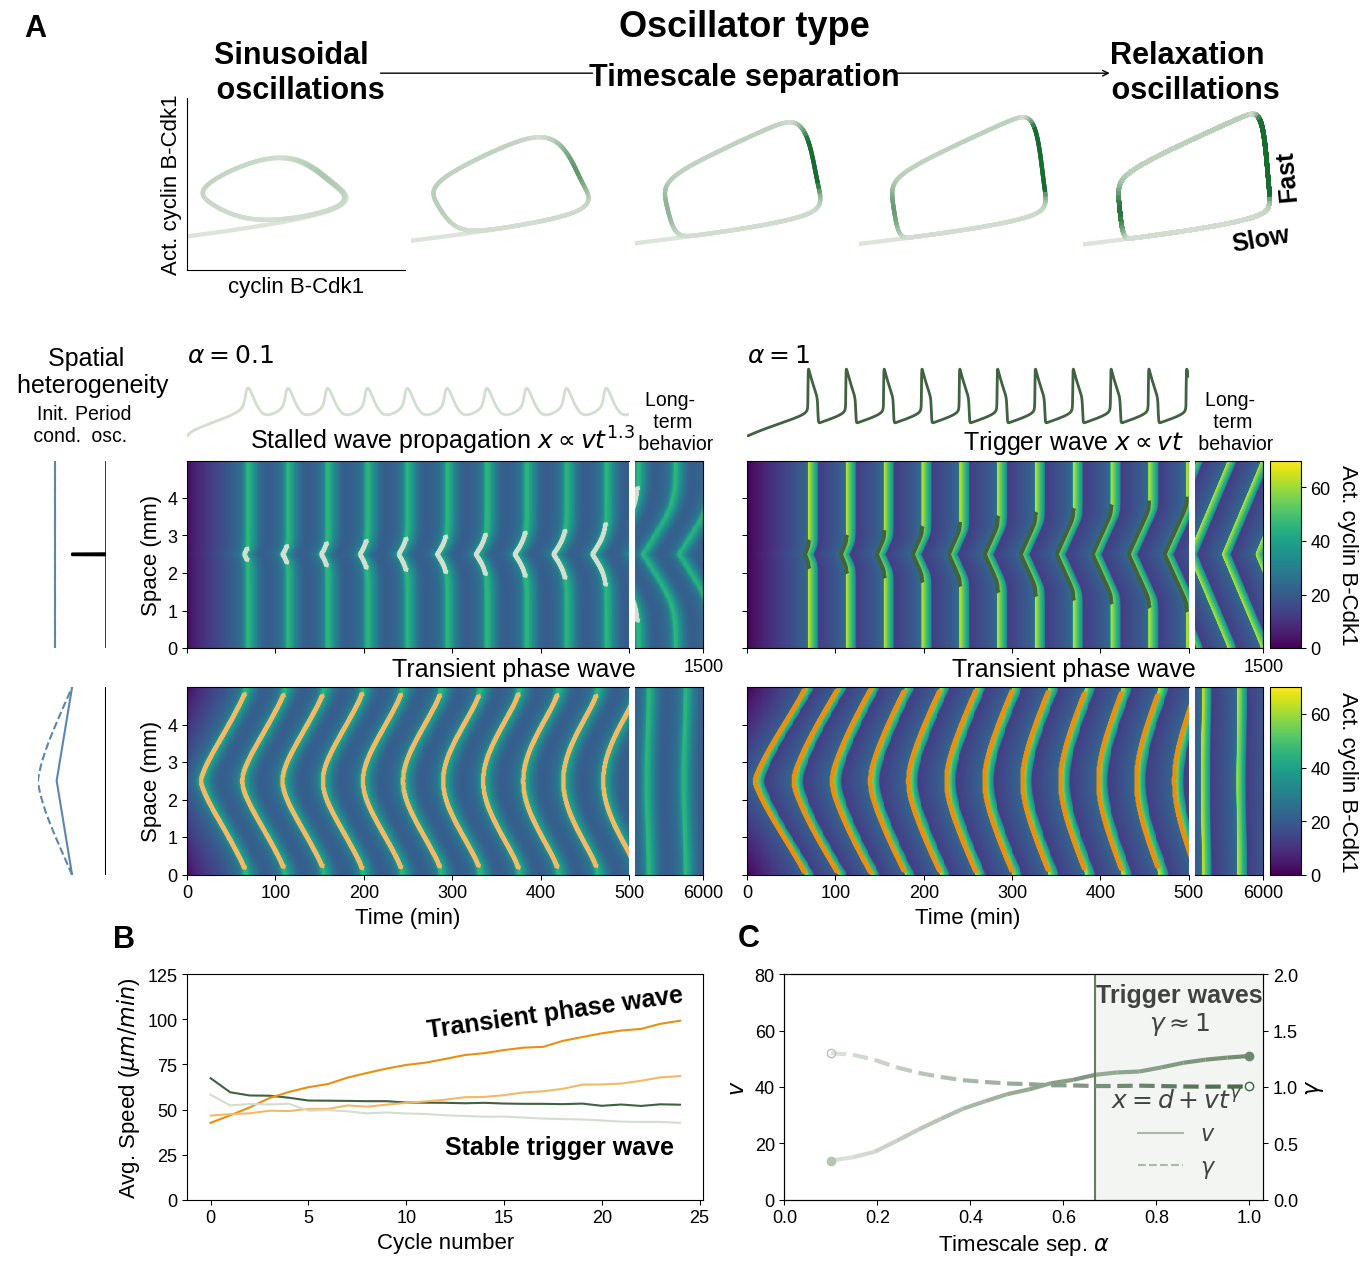

In [40]:
size = 15
nrows = 184
fig = plt.figure(figsize=(1.6*size,size*nrows/153))#,constrained_layout=True)
ax0   = plt.subplot2grid((nrows, 50), (00, 4), rowspan = 23, colspan = 6) # phase space
ax01  = plt.subplot2grid((nrows, 50), (00, 10), rowspan = 23, colspan = 6) # phase space
ax02  = plt.subplot2grid((nrows, 50), (00, 16), rowspan = 23, colspan = 6) # phase space
ax03  = plt.subplot2grid((nrows, 50), (00, 22), rowspan = 23, colspan = 6) # phase space
ax04  = plt.subplot2grid((nrows, 50), (00, 28), rowspan = 23, colspan = 6) # phase space

# ax10  = plt.subplot2grid((nrows, 50), (146, 10), rowspan = 30, colspan = 17) # alpha scan
ax10  = plt.subplot2grid((nrows, 50), (116, 20), rowspan = 30, colspan = 13) # alpha scan

# ax11  = plt.subplot2grid((157, 50), (100, 7), rowspan = 28, colspan = 28)

ax200 = plt.subplot2grid((nrows, 50), (35, 4), rowspan = 10, colspan = 12) #Time series
ax201 = plt.subplot2grid((nrows, 50), (35, 19), rowspan = 10, colspan = 12) #Time series

ax210 = plt.subplot2grid((nrows, 50), (48, 4), rowspan = 25, colspan = 12) #kymo up-left
ax211 = plt.subplot2grid((nrows, 50), (48, 19), rowspan = 25, colspan = 12) #kymo up-right
ax212 = plt.subplot2grid((nrows, 50), (48, 0), rowspan = 25, colspan = 2) #IC and tau up
cax1  = plt.subplot2grid((nrows, 50), (48, 33), rowspan = 25, colspan = 1) #Colorbar up
ax213 = plt.subplot2grid((nrows, 50), (48, 16), rowspan = 25, colspan = 2) #kymo up-left
ax214 = plt.subplot2grid((nrows, 50), (48, 31), rowspan = 25, colspan = 2) #kymo up-right

ax220 = plt.subplot2grid((nrows, 50), (78, 4), rowspan = 25, colspan = 12) #kymo down-left
ax221 = plt.subplot2grid((nrows, 50), (78, 19), rowspan = 25, colspan = 12) #kymo down-right
ax222 = plt.subplot2grid((nrows, 50), (78, 0), rowspan = 25, colspan = 2) #IC and tau down
cax2  = plt.subplot2grid((nrows, 50), (78, 33), rowspan = 25, colspan = 1) #Colorbar down
ax223 = plt.subplot2grid((nrows, 50), (78, 16), rowspan = 25, colspan = 2) #kymo up-left
ax224 = plt.subplot2grid((nrows, 50), (78, 31), rowspan = 25, colspan = 2) #kymo up-right

# ax230 = plt.subplot2grid((nrows, 50), (109, 4), rowspan = 25, colspan = 14) # Time evolution left
ax231 = plt.subplot2grid((nrows, 50), (116, 4), rowspan = 30, colspan = 14) # Time evolution right

cols = ['#416241','#e27e12','#EA9010','#D2DECF','#E9EEE7','#F4B966']
# cols = ['#416241','#e27e12','#4357AD','#D2DECF','#E9EEE7','#98A4D7']
# cols = ['#416241','#e27e12','#5E46AF','#D2DECF','#E9EEE7','#CC59D2']



folder = 'sim/scan-phase-trigger/icpeak/'
alphas = np.linspace(0.1,1,20)
ax10y = ax10.twinx()
plot_alphascan(ax10,ax10y,folder,chi,alphas,colors= [cols[4],cols[0]])

folders = ['sim/scan-phase-trigger/icpeak-better-dt-phaseplane/sim-{}/'.format(i) for i in [0,2,7,12,19]]
axis_list = [True,False,False,False,False]
axi = [ax0,ax01,ax02,ax03,ax04]
cmap = custom_colormap([cols[3],cols[0]])
greens = cmap(np.linspace(0,1,5))
bars = [False,False,False,False,False]
for el, el1, el2, col, b in zip(folders,axi,axis_list,greens,bars):
    plot_phaseplane_color_timescale_sep(el1,el,color=col,axis = el2,plot_cbar=b)

i=19
folder = 'sim/scan-phase-trigger/icpeak/sim-{}/'.format(i)
folder1 = 'sim/scan-phase-trigger/icpeak-better-dt-phaseplane/sim-{}/'.format(i)

plot_evol_speed(ax231,folder,chi,color=cols[0],plot_yaxis=True)
plot_timeseries_fig5(ax201,folder1,color=cols[0])
plot_kymo_fig5_1(ax211,ax212,ax214,cax1,folder1,chi,plot_xaxis=False,plot_yaxis=False,plot_waves=True,plot_ictau=False,plot_ic=False,color=cols[0],tlim=1500,colormap='viridis')
folder = 'sim/scan-phase-trigger/ictriangle-long/sim-{}/'.format(i)
plot_evol_speed(ax231,folder,chi,color=cols[2],plot_yaxis=True)
plot_kymo_fig5_1(ax221,ax222,ax224,cax2,folder,chi,plot_xaxis=True,plot_yaxis=False,plot_waves=True,plot_ictau=False,plot_ic=False,color=cols[2],tlim=6000,colormap='viridis')

i=0
folder = 'sim/scan-phase-trigger/icpeak/sim-{}/'.format(i)

plot_timeseries_fig5(ax200,folder,color=cols[3])
plot_kymo_fig5_1(ax210,ax212,ax213,cax1,folder,chi,plot_ictau=True,plot_ic=True,plot_cbar=False,plot_xaxis=False,plot_waves=True,color=cols[3],tlim=1500,colormap='viridis')
folder = 'sim/scan-phase-trigger/ictriangle-long/sim-{}/'.format(i)
plot_evol_speed(ax231,folder,chi,color=cols[5])
plot_kymo_fig5_1(ax220,ax222,ax223,cax2,folder,chi,plot_ictau=True,plot_ic=True,plot_cbar=False,plot_xaxis=True,plot_waves=True,color=cols[5],tlim=6000,colormap='viridis')
folder = 'sim/scan-phase-trigger/icpeak/sim-{}/'.format(i)
plot_evol_speed(ax231,folder,chi,color=cols[3])

ax04.text(67,8,r'Slow',fontsize=18,color='black',weight='bold',rotation = 10)
ax04.text(75,30,r'Fast',fontsize=18,color='black',weight='bold',rotation = 95)
ax0.text(10,95,r'A',fontsize=22,color='black',weight='bold')
ax0.text(60,70,'Sinusoidal \n oscillations',fontsize=22,color='black',weight='bold',horizontalalignment='center')
ax02.text(60,95,r'Oscillator type',fontsize=26,color='black',weight='bold',horizontalalignment='center')
ax02.text(60,75,r'Timescale separation',fontsize=22,color='black',weight='bold',horizontalalignment='center')
ax04.text(60,70,'Relaxation \n oscillations',fontsize=22,color='black',weight='bold',horizontalalignment='center')


ax0.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

# ax10.text(0.58,78,r'$Trigger$ $wave$ $regime$',fontsize=18,color='black',weight='bold')
# ax10.text(0.4,88,r'$Phase$ $wave$ $regime$',fontsize=18,color='black',weight='bold')

ax231.text(-5,140,r'B',fontsize=22,color='black',weight='bold')
ax231.text(12,25,r'Stable trigger wave',fontsize=18,color='black',weight='bold')
ax231.text(11,90,r'Transient phase wave',fontsize=18,color='black',weight='bold',rotation =8)
# ax230.text(14,25,r'Stable trigger wave',fontsize=18,color='black',weight='bold')
# ax230.text(13,64,r'Transient phase wave',fontsize=18,color='black',weight='bold',rotation =6)

# ax212.text(1,0.5,r'$\tau(x)$',rotation='vertical',fontsize=18)
# ax222.text(1.2,0.5,r'$\tau(x)$',rotation='vertical',fontsize=18)
# ax222.text(1,0.5,r'IC',rotation='vertical',fontsize=18,color='#5C87AD')
ax200.text(0,70,r'$\alpha=0.1$',fontsize=18)
ax201.text(0,70,r'$\alpha=1$',fontsize=18)

ax210.text(550,5.3,'Long- \n term \n behavior',fontsize=14,horizontalalignment='center')
ax211.text(550,5.3,'Long- \n term \n behavior',fontsize=14,horizontalalignment='center')
ax210.text(290,5.3,'Stalled wave propagation $x \propto vt^{1.3}$ ',fontsize=18,horizontalalignment='center')
ax211.text(370,5.3,'Trigger wave $x \propto vt$',fontsize=18,horizontalalignment='center')
ax220.text(370,5.3,'Transient phase wave',fontsize=18,horizontalalignment='center')
ax221.text(370,5.3,'Transient phase wave',fontsize=18,horizontalalignment='center')


ax212.text(0.5,6.8,'Spatial \n heterogeneity',fontsize=18,horizontalalignment='center')
ax212.text(0,5.5,'Period \n osc.',fontsize = 14, horizontalalignment='center')
ax212.text(1.5,5.5,'Init. \n cond.',fontsize = 14, horizontalalignment='center')

ax10.text(-0.1,90,r'C',fontsize=22,color='black',weight='bold')
ax10.text(0.85,70,'Trigger waves',fontsize=18,color='black',weight='bold',horizontalalignment='center')
ax10.text(0.85,60,r'$\gamma \approx 1$',fontsize=18,color='black',weight='bold',horizontalalignment='center')
ax0.annotate("",xy=(115, 80), xycoords='data',xytext=(75, 80), textcoords='data',arrowprops=dict(arrowstyle="-"), annotation_clip=False)
ax0.annotate("",xy=(210, 80), xycoords='data',xytext=(170, 80), textcoords='data',arrowprops=dict(arrowstyle="->"), annotation_clip=False)

x = [22.5,22.5]
y = [112,28]

# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/fig5v7.pdf',bbox_inches='tight',dpi=300)

plt.savefig("5A.pdf", bbox_inches='tight')
plt.show()

# <b>Supplementary Figures</b>

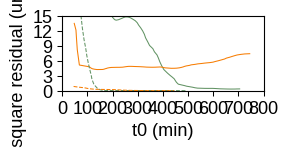

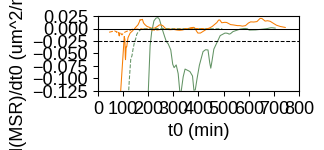

In [41]:
fig = plt.figure()
ax = plt.gca()

fig2 = plt.figure()
ax2 = plt.gca()

dl_thres = 0.025

q = detect_tail(wnx_S, 1 / wny_S, ax=ax, ax2=ax2, linespec='-', color="#629364", fname="S1-1.csv")
q = detect_tail(wnx_n_S, 1 / wny_n_S, ax=ax, ax2=ax2, linespec='-', color="#F77D03", fname="S1-2.csv")
q = detect_tail(wnx_S_csf, 1 / wny_S_csf, ax=ax, ax2=ax2, linespec='--', color="#629364", fname="S1-3.csv")
q = detect_tail(wnx_n_S_csf, 1 / wny_n_S_csf, ax=ax, ax2=ax2, linespec='--', color="#F77D03", fname="S1-4.csv")

ax.set_xlim([0, 800])
ax.set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax.set_ylim([0, 15])
ax.set_yticks([0, 3, 6, 9, 12, 15])
ax2.set_xlim([0, 800])
ax2.set_xticks([0, 100, 200, 300, 400, 500, 600, 700, 800])
ax2.set_yticks([-0.125, -0.1, -0.075, -0.05, -0.025, 0, 0.025])
ax2.plot([0, 800], [-dl_thres, -dl_thres], 'k--', linewidth=0.75)
ax2.plot([0, 800], [0, 0], 'k', linewidth=0.75)

ax.set_xlabel("t0 (min)")
ax2.set_xlabel("t0 (min)")

ax.set_ylabel("Mean square residual (um^2/min^2)")
ax2.set_ylabel("d(MSR)/dt0 (um^2/min^3)")

set_size(ax, 2, 0.75)
set_size(ax2, 2, 0.75)

fig.savefig("S_tau0_1.pdf", bbox_inches="tight")
fig2.savefig("S_tau0_2.pdf", bbox_inches="tight")


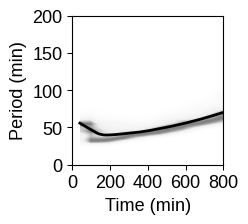

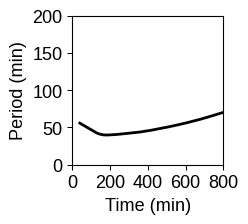

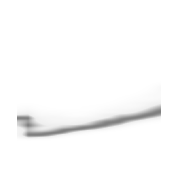

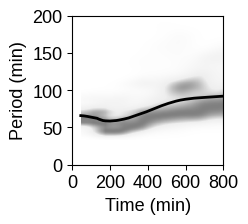

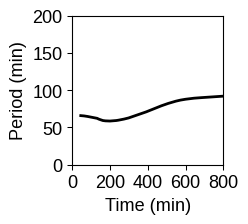

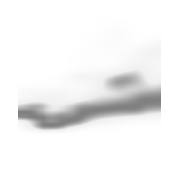

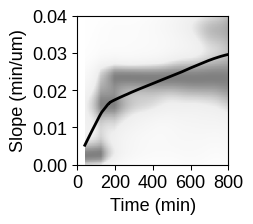

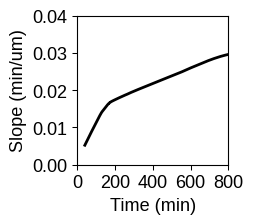

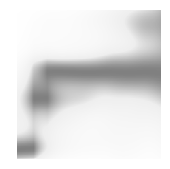

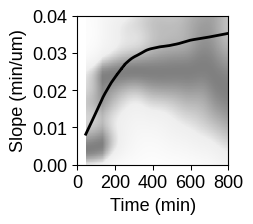

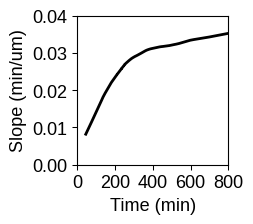

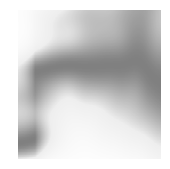

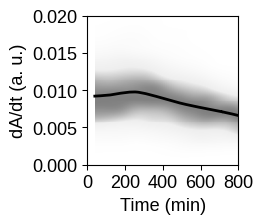

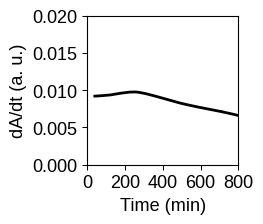

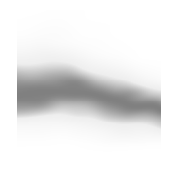

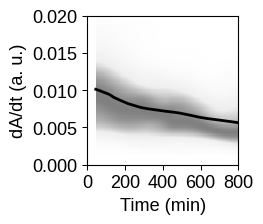

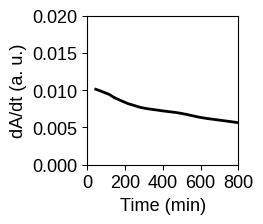

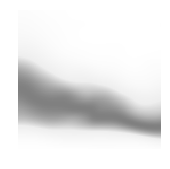

In [42]:
size = (1.5, 1.5)

# periods
fig = plt.figure()
ax = plt.gca()
plot_kde(xx_T_csf, yy_T_csf, dens_T_csf, wnx_T_csf, wny_T_csf, xticks=[200 * i for i in range(5)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("S_csf_per.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_T_csf, yy_T_csf, dens_T_csf, wnx_T_csf, wny_T_csf, xticks=[200 * i for i in range(5)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("S_csf_per-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_T_csf, yy_T_csf, dens_T_csf, wnx_T_csf, wny_T_csf, xticks=[200 * i for i in range(5)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("S_csf_per.png", bbox_inches="tight")

writetocsv("S_csf_per.csv", wnx_T_csf, wny_T_csf)

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_T_csf, yy_n_T_csf, dens_n_T_csf, wnx_n_T_csf, wny_n_T_csf, xticks=[200 * i for i in range(5)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("S_n_csf_per.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_T_csf, yy_n_T_csf, dens_n_T_csf, wnx_n_T_csf, wny_n_T_csf, xticks=[200 * i for i in range(5)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("S_n_csf_per-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_T_csf, yy_n_T_csf, dens_n_T_csf, wnx_n_T_csf, wny_n_T_csf, xticks=[200 * i for i in range(5)], yticks=[50 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Period (min)")
plt.savefig("S_n_csf_per.png", bbox_inches="tight")

writetocsv("S_n_csf_per.csv", wnx_n_T_csf, wny_n_T_csf)

# slopes
fig = plt.figure()
ax = plt.gca()
plot_kde(xx_S_csf, yy_S_csf, dens_S_csf, wnx_S_csf, wny_S_csf, xticks=[200 * i for i in range(5)], yticks=[0.01 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("S_csf_sl.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_S_csf, yy_S_csf, dens_S_csf, wnx_S_csf, wny_S_csf, xticks=[200 * i for i in range(5)], yticks=[0.01 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("S_csf_sl-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_S_csf, yy_S_csf, dens_S_csf, wnx_S_csf, wny_S_csf, xticks=[200 * i for i in range(5)], yticks=[0.01 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("S_csf_sl.png", bbox_inches="tight")

writetocsv("S_csf_sl.csv", wnx_S_csf, wny_S_csf)

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_S_csf, yy_n_S_csf, dens_n_S_csf, wnx_n_S_csf, wny_n_S_csf, xticks=[200 * i for i in range(5)], yticks=[0.01 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("S_n_csf_sl.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_S_csf, yy_n_S_csf, dens_n_S_csf, wnx_n_S_csf, wny_n_S_csf, xticks=[200 * i for i in range(5)], yticks=[0.01 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("S_n_csf_sl-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_S_csf, yy_n_S_csf, dens_n_S_csf, wnx_n_S_csf, wny_n_S_csf, xticks=[200 * i for i in range(5)], yticks=[0.01 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Slope (min/um)")
plt.savefig("S_n_csf_sl.png", bbox_inches="tight")

writetocsv("S_n_csf_sl.csv", wnx_n_S_csf, wny_n_S_csf)

# dA/dt
fig = plt.figure()
ax = plt.gca()
plot_kde(xx_A_csf, yy_A_csf, dens_A_csf, wnx_A_csf, wny_A_csf, xticks=[200 * i for i in range(5)], yticks=[0.005 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_csf_act.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_A_csf, yy_A_csf, dens_A_csf, wnx_A_csf, wny_A_csf, xticks=[200 * i for i in range(5)], yticks=[0.005 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_csf_act-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_A_csf, yy_A_csf, dens_A_csf, wnx_A_csf, wny_A_csf, xticks=[200 * i for i in range(5)], yticks=[0.005 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_csf_act.png", bbox_inches="tight")

writetocsv("S_csf_act.csv", wnx_A_csf, wny_A_csf)

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_A_csf, yy_n_A_csf, dens_n_A_csf, wnx_n_A_csf, wny_n_A_csf, xticks=[200 * i for i in range(5)], yticks=[0.005 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_n_csf_act.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_A_csf, yy_n_A_csf, dens_n_A_csf, wnx_n_A_csf, wny_n_A_csf, xticks=[200 * i for i in range(5)], yticks=[0.005 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_n_csf_act-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_A_csf, yy_n_A_csf, dens_n_A_csf, wnx_n_A_csf, wny_n_A_csf, xticks=[200 * i for i in range(5)], yticks=[0.005 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_n_csf_act.png", bbox_inches="tight")

writetocsv("S_n_csf_act.csv", wnx_n_A_csf, wny_n_A_csf)



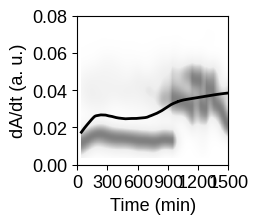

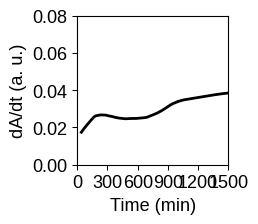

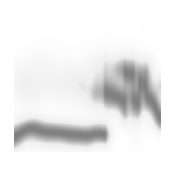

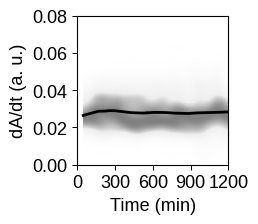

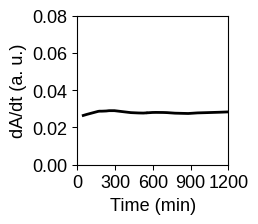

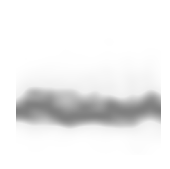

In [43]:
size = (1.5, 1.5)

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_A, yy_A, dens_A, wnx_A, wny_A, xticks=[300 * i for i in range(6)], yticks=[0.02 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_act.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_A, yy_A, dens_A, wnx_A, wny_A, xticks=[300 * i for i in range(6)], yticks=[0.02 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_act-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_A, yy_A, dens_A, wnx_A, wny_A, xticks=[300 * i for i in range(6)], yticks=[0.02 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_act.png", bbox_inches="tight")

writetocsv("S_act.csv", wnx_A, wny_A)

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_A, yy_n_A, dens_n_A, wnx_n_A, wny_n_A, xticks=[300 * i for i in range(5)], yticks=[0.02 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_n_act.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_A, yy_n_A, dens_n_A, wnx_n_A, wny_n_A, xticks=[300 * i for i in range(5)], yticks=[0.02 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_n_act-line.pdf", bbox_inches="tight")

fig = plt.figure()
ax = plt.gca()
plot_kde(xx_n_A, yy_n_A, dens_n_A, wnx_n_A, wny_n_A, xticks=[300 * i for i in range(5)], yticks=[0.02 * i for i in range(5)], fit=False, fig=fig, ax=ax, draw_density=True, draw_axis=False, col1='k')
set_size(ax, *size)
ax.set_xlabel("Time (min)")
ax.set_ylabel("dA/dt (a. u.)")
plt.savefig("S_n_act.png", bbox_inches="tight")

writetocsv("S_n_act.csv", wnx_n_A, wny_n_A)


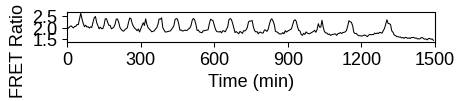

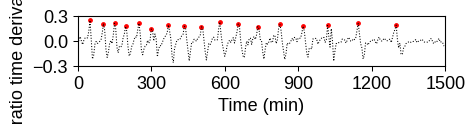

In [44]:
dir_single = dir_dd['exp']['030222 (Cdc25 Inhib)']['Pos1 (0 uM no nuc)']['Tube4Ratio_Montage.tif']
dat_single = extract_data_v1(dir_single)

size = 5
#fig=plt.figure(figsize=(2.66*size,size))
dt=5.0

act = dir_single['Activity'][0,:300]
plt.plot(dir_single['t'][:300],act,'#A4C2A5',zorder=-10,linewidth=0.75,color='k')
temp = dat_single[np.argwhere(dat_single[:,-3]==dir_single['x'][0]),-2]
temptemp = temp[:,0]/5
plt.scatter(temp,act[temptemp.astype('int')],c='#574D68')

plt.xlabel('Time (min)')
plt.ylabel('FRET Ratio (a.u.)')
plt.xlim([0,1500])
plt.xticks([300 * i for i in range(6)])
plt.yticks([1.5, 2, 2.5])

ax = plt.gca()
set_size(ax, 3.65, .3)

__test = np.gradient(act)
__test_ = signal.find_peaks(__test, prominence=0.25)
__y = act[__test_[0]]
__x = dir_single['t'][__test_[0]]
#plt.scatter(__x, __y, c='r', s=6)

plt.savefig("S_dadt1.pdf", bbox_inches='tight')

fig = plt.figure()
ax = plt.gca()

plt.plot(dir_single['t'][:300],np.gradient(act), 'k:', linewidth=0.75)
plt.scatter(__x, np.gradient(act)[__test_[0]], c='r', s=6)
ax.set_xlabel("Time (min)")
ax.set_ylabel("FRET ratio time derivative (1/min)")
plt.xticks([300 * i for i in range(6)])
plt.yticks([-0.3, 0, 0.3])
plt.xlim([0,1500])

ax = plt.gca()
set_size(ax, 3.65, .5)

plt.savefig("S_dadt2.pdf", bbox_inches='tight')


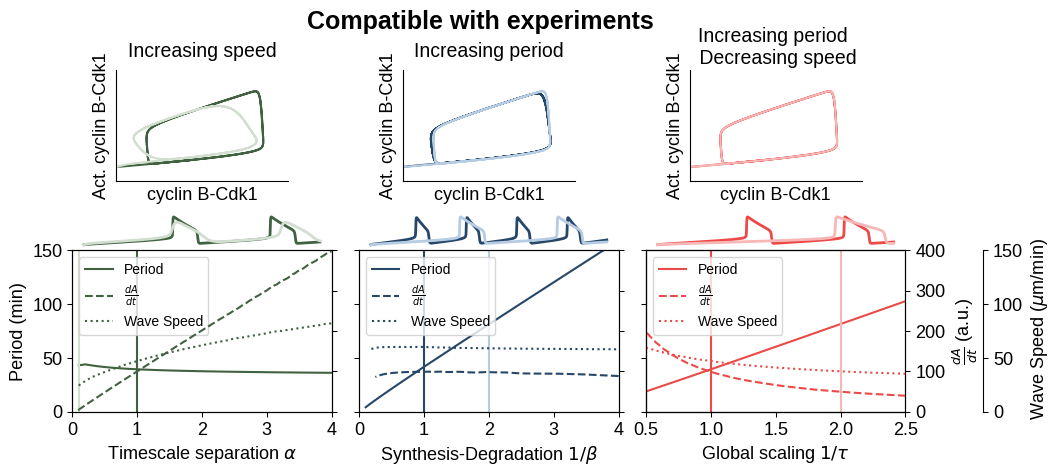

In [45]:

cols = [['#D2DECF','#6A966B','#416241'],
        ['#B5CCE3','#6796C5','#274768'],
        ['#F7B7B6','#EF6E6C','#EB4A47']]
cmap_0 = custom_colormap([cols[0][0],cols[0][2]])
cmap_1 = custom_colormap([cols[1][0],cols[1][2]])
cmap_2 = custom_colormap([cols[2][0],cols[2][2]])

in_0 = chang2013model(p_0)
in_0.tf_timeseries = 150
in_0.nt_timeseries = 1000


# plt.rcParams.update({'font.size': 12})
size = 7
fig = plt.figure(figsize=(1.6*size,2*size/3))#,constrained_layout=True)
nrow, ncol = 100,100
ax0 = plt.subplot2grid((nrow, ncol), (0, 5), rowspan = 31, colspan = 20)
ax1 = plt.subplot2grid((nrow, ncol), (0, 38), rowspan = 31, colspan = 20)
ax2 = plt.subplot2grid((nrow, ncol), (0, 71), rowspan = 31, colspan = 20)
ax3 = plt.subplot2grid((nrow, ncol), (50, 0), rowspan = 45, colspan = 30)
ax4 = plt.subplot2grid((nrow, ncol), (50, 33), rowspan = 45, colspan = 30)
ax5 = plt.subplot2grid((nrow, ncol), (50, 66), rowspan = 45, colspan = 30)
ax6 = plt.subplot2grid((nrow, ncol), (40, 0), rowspan = 10, colspan = 30)
ax7 = plt.subplot2grid((nrow, ncol), (40, 33), rowspan = 10, colspan = 30)
ax8 = plt.subplot2grid((nrow, ncol), (40, 66), rowspan = 10, colspan = 30)

tf, nt = 200,1000
in_1 = chang2013model(dict(p_0, alpha=1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax0,xlim=[40,80],ylim = [0,80],color = cols[0][2],axis=True)
plot_timeseries_fig2(in_1, ax6,color = cols[0][2])


in_1 = chang2013model(dict(p_0, alpha=.1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax0,xlim=[40,80],ylim = [0,80],color = cols[0][0],axis=True)
plot_timeseries_fig2(in_1, ax6,color = cols[0][0])


in_1 = chang2013model(dict(p_0, beta=1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax1,xlim=[40,80],ylim = [0,80],color = cols[1][2],axis=True)
plot_timeseries_fig2(in_1, ax7,color = cols[1][2])

in_1 = chang2013model(dict(p_0, beta=0.5))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax1,xlim=[40,80],ylim = [0,80],color = cols[1][0],axis=True)
plot_timeseries_fig2(in_1, ax7,color = cols[1][0])



in_1 = chang2013model(dict(p_0, tau=1))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax2,xlim=[40,80],ylim = [0,80],color = cols[2][2],axis=True)
plot_timeseries_fig2(in_1, ax8,color = cols[2][2])

in_1 = chang2013model(dict(p_0, tau=0.5))
in_1.tf_timeseries = tf
in_1.nt_timeseries = nt
plot_phaseplane_fig2(in_1,ax2,xlim=[40,80],ylim = [0,80],color = cols[2][0],axis=True)
plot_timeseries_fig2(in_1, ax8,color = cols[2][0])



folders = ['sim/disp-rel/alpha_scan/param_speed_period.npy','sim/alpha-period-amp.npy']
plot_period_dadt_speed(ax3,folders,chi,
                           labelx = r'Timescale separation $\alpha$',
                           col = cols[0][2],yaxis=True,twinxaxis=False,xrange=[0,4])

folders = ['sim/disp-rel/beta_scan/param_speed_period.npy','sim/beta-period-amp.npy']
plot_period_dadt_speed(ax4,folders,chi,
                           labelx = r'Synthesis-Degradation $1/\beta$',
                           col = cols[1][2],yaxis=False,twinxaxis=False,xrange=[0,4],inverse_param=True)

folders = ['sim/disp-rel/tau_scan/param_speed_period.npy','sim/tau-period-amp.npy']
plot_period_dadt_speed(ax5,folders,chi,
                           labelx = r'Global scaling $1/\tau$',
                           col = cols[2][2],yaxis=False,twinxaxis=True,xrange=[0.5,2.5],inverse_param=True)
ax3.axvline(.1,c=cols[0][0])
ax3.axvline(1,c=cols[0][2])

ax4.axvline(2,c=cols[1][0])
ax4.axvline(1,c=cols[1][2])

ax5.axvline(2,c=cols[2][0])
ax5.axvline(1,c=cols[2][2])

# ax0.text(20,110,'a',fontsize=14,color='black',weight='bold')
ax1.text(58,110,'Compatible with experiments',fontsize=18,color='black',weight='bold',horizontalalignment='center')
ax0.text(60,90,'Increasing speed',fontsize=14,color='black',horizontalalignment='center')
ax1.text(60,90,'Increasing period',fontsize=14,color='black',horizontalalignment='center')
ax2.text(60,85,'Increasing period \n Decreasing speed',fontsize=14,color='black',horizontalalignment='center')

# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/mitotic_figs3-v1.pdf',bbox_inches='tight',dpi=300)

plt.show()

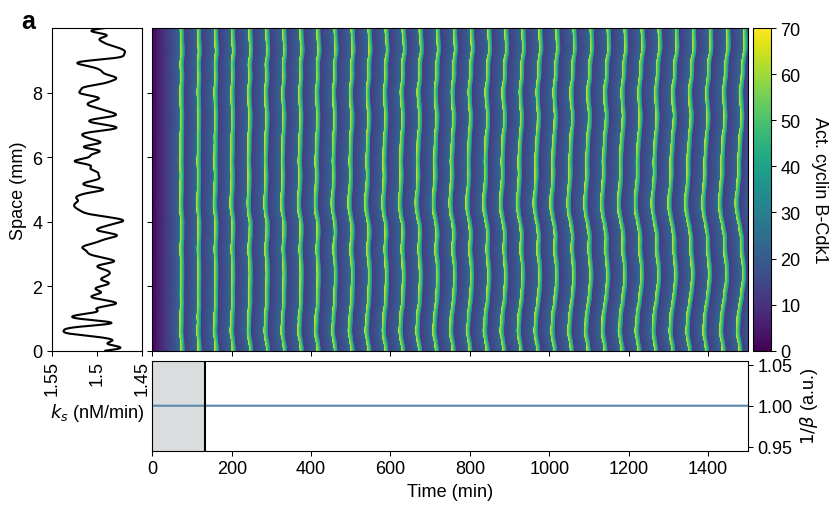

In [46]:
size = 4.5
fig = plt.figure(figsize=(1.7*size,size),constrained_layout=True)
ax = plt.subplot2grid((1, 1), (0, 0), colspan=60)

folder = 'sim/mit-waves31/'
plot_kymo_figure_s1(ax,folder,chi,133.5133513351335,colormap='viridis')
ax.text(-330,10,'a',color='black',fontweight="bold",fontsize=18)

# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/figs4av1.pdf',bbox_inches='tight',dpi=300)
plt.show()

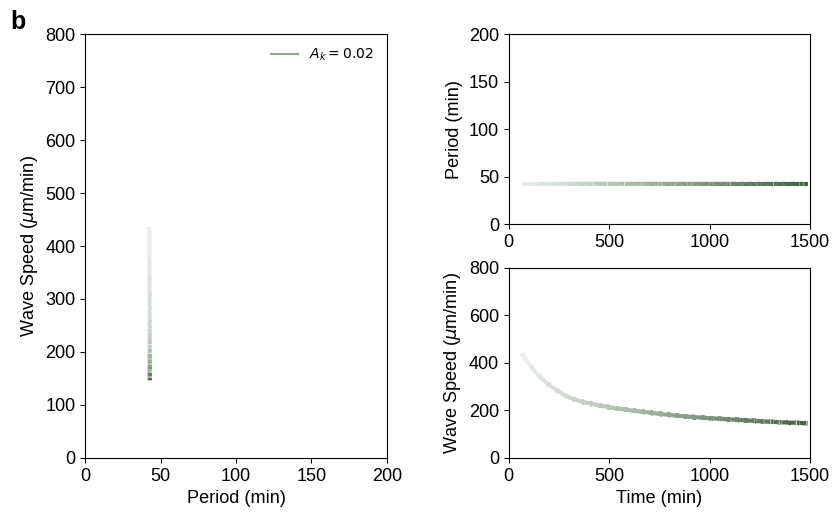

In [47]:
path_disp = 'sim/disp-rel/beta_scan/param_speed_period.npy'
lw = 3
# cols = ['#A4C2A5','#37526C','#6A90B4','#E086D3','#462749']
cols = [['#E7EFE7','#416241'],['#FCEBD9','#97540C'],['#E4EBF1','#37536C'],['#F7DEEA','#B52C6E'],['#F0E4F1','#66396A']]
line_labels = [r'$A_{k}=0.02$', r'$A_{k}=0.05$',r'Low period',r'High period',r'Long transient',r'Long trans., high $A_{k}$']

size = 5.5
fig = plt.figure(figsize=(1.7*size,size))
ax0 = plt.subplot2grid((100, 120), (0, 0), colspan=50,rowspan=100)
ax1 = plt.subplot2grid((100, 120), (0, 70), colspan=50,rowspan=45)
ax2 = plt.subplot2grid((100, 120), (55, 70), colspan=50,rowspan=45)

labels = [r'Time (min)',r'Period (min)',r'Wave Speed ($\mu$m/min)']
ax0.set_xlabel(labels[1])
ax0.set_ylabel(labels[2])
ax1.set_ylabel(labels[1])
ax2.set_ylabel(labels[2])
ax2.set_xlabel(labels[0])

# with open(path_disp, 'rb') as f:
#     param_scan = np.load(f)
#     speeds = np.load(f)
#     periods = np.load(f)
# ax0.plot(periods[~np.isnan(speeds)],(abs(speeds[~np.isnan(speeds)])*chi*1e3),c='k',label=r'Dispersion relation',linestyle='dashed')



handles, labels = ax0.get_legend_handles_labels()

folder = r'sim/mit-waves31/'
x_p_real, y_p_real, x_s_real, y_s_real = get_dispersion_relation(folder,chi, plot=False)

# folder = '../sim/disp-rel/beta_scan/sim-85/'
# x_p_85, y_p_85, x_s_85, y_s_85 = get_dispersion_relation(folder,chi, plot=False,resize = 512)

# folder = '../sim/disp-rel/beta_scan/sim-53/'
# x_p_53, y_p_53, x_s_53, y_s_53 = get_dispersion_relation(folder,chi, plot=False,resize = 512)

cmap = custom_colormap(cols[0])
line0 = Line2D([0], [0], label=line_labels[0], color=cmap(0.5))
plot_xyt1(ax0,ax1,ax2, y_p_real, 1/y_s_real, x_p_real, cols[0])


# ax0.plot(y_p_85[-1], 1/y_s_85[-1],'o',c=cols[2][-1])
# ax1.axhline(y_p_85[-1],linestyle='dotted',c=cols[2][1])
# ax2.axhline(1/y_s_85[-1],linestyle='dotted',c=cols[2][1])
# ax0.plot(y_p_53[-1], 1/y_s_53[-1],'o',c=cols[3][-1])
# ax1.axhline(y_p_53[-1],linestyle='dashed',c=cols[3][1])
# ax2.axhline(1/y_s_53[-1],linestyle='dashed',c=cols[3][1])



#add legend
handles.extend([line0])
ax0.legend(frameon=False,handles=handles)

# ax1.legend(frameon=False, fontsize=10)
# ax2.legend(frameon=False, fontsize=10)
# ax0.set_yscale('log')
# ax2.set_yscale('log')
ax0.set_xlim(0,200)
ax0.set_ylim(0,800)
ax1.set_xlim(0,1500)
ax1.set_ylim(0,200)
ax2.set_xlim(0,1500)
ax2.set_ylim(0,800)
ax0.text(-50,810,'b',color='black',fontweight="bold",fontsize=18)
# plt.savefig(os.environ['HOME']+'/Documents/cc/data-yang/prolit/figs/panels_owen/figs4bv1.pdf',bbox_inches='tight',dpi=500)

plt.show()